# <b> <font color='#A20025'> 📚 Chapter 11: Graph Neural Networks for Predicting Drug-Target Interactions


*This notebook contains the code examples in chapter 11. For readability, the chapter notebooks only contain runnable code blocks and section titles. They omit the rest of the material in the book, i.e., text paragraphs, figures (unless generated as part of one of the code blocks), equations, and pseudocode. I recommend reading the notebooks side-by-side with the book!*

You can work through this notebook locally as well as via Google Colab:
<a target="_blank" href="https://colab.research.google.com/github/nrflynn2/ml-drug-discovery/blob/main/CH11_FLYNN_ML4DD.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This chapter covers:
- 

> 💡 **Companion Reading**: This notebook accompanies Chapter 11 of "Machine Learning for Drug Discovery". 
> The textbook provides deeper theoretical insights, mathematical derivations, and comprehensive explanations 
> that complement this hands-on implementation.


## <b> <font color='#A20025'> ⚙️ Environment Setup

**❗️LOCAL ENVIRONMENT:** If you are running the Python notebook locally on your computer, then we recommend following the README setup instructions on how to use conda (or a similar package) to set up an environment using the file `ml4dd2025.yml`

**❗️COLAB ENVIRONMENT:** If you are running the code via an instance on Google Colab, you can download the necessary files and create the environment by running the following cells marked as **Colab users only**.

In [ ]:
# Colab users only
import os
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("🌐 Running in Google Colab - setting up environment...")
    
    # Create directory structure
    dirs = [
        "artifacts/ch11",
        "data/ch11/davis",
        "data/ch11/kiba",
        "figures/ch11"
    ]
    for dir_path in dirs:
        os.makedirs(dir_path, exist_ok=True)
    
    # Download data files
    base_url = "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main"
    files = {
        "env.yml": f"{base_url}/ml4dd2025.yml"
    }
    
    for local_path, url in files.items():
        if not os.path.exists(local_path):
            os.system(f'wget -q "{url}" -O "{local_path}"')
            print(f"  ✓ Downloaded {local_path}")

In [ ]:
# Colab users only - Install conda environment
if IN_COLAB:
    %pip install -q condacolab
    import condacolab
    condacolab.install() #  The kernel will restart after this cell has run, which is normal.

In [ ]:
# Colab only - Update environment with dependencies
if IN_COLAB:
    import condacolab
    condacolab.check()
    !mamba env update -n base -f env.yml

### <b> <font color='#A20025'> Import Packages 

Now let's import all the packages we'll need for this chapter.

In [1]:
import os
import json
import pickle
import random
import warnings
from collections import OrderedDict
from typing import Tuple, List, Dict, Optional, Union
from math import sqrt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# Scientific computing
from scipy import stats
from sklearn.metrics import mean_squared_error

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

# PyTorch Geometric
from torch_geometric.data import Data, InMemoryDataset, DataLoader, Batch
from torch_geometric.nn import GCNConv, GATConv, GINConv, Sequential
from torch_geometric.nn import global_mean_pool, global_add_pool, global_max_pool

# RDKit for molecular processing
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
import networkx as nx

warnings.filterwarnings('ignore')

/home/noahrf/anaconda3/envs/ml4dd_py311/lib/python3.11/site-packages/seaborn/_statistics.py:32: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.1)
  from scipy.stats import gaussian_kde
/home/noahrf/anaconda3/envs/ml4dd_py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 ### <b> <font color='#A20025'> Setup Configuration

In [2]:
# Set random seeds for reproducibility
def set_seed(seed=42):
    """Set random seeds for reproducibility across all libraries."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

In [25]:
# Centralized Configuration
CONFIG = {
    # Random seed
    'seed': 42,

    # Device settings
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',

    # Model hyperparameters
    'num_features_mol': 78,  # Molecular node feature dimension
    'num_features_pro': 54,  # Protein node feature dimension (full PSSM)
    'num_features_pro_simplified': 33,  # Protein node feature dimension (no PSSM)
    'output_dim': 128,  # Embedding dimension
    'dropout': 0.2,

    # Training hyperparameters
    'batch_size': 512,
    'learning_rate': 0.001,
    'epochs': 2000,
    'log_interval': 10,

    # Demo settings
    'demo_samples': 100,  # Number of samples for demo dataset
    'demo_train_ratio': 0.8,  # Train/val split ratio
    'demo_epochs': 30,
    'demo_batch_size': 16,

    # Data loading settings
    'use_full_dataset': False,  # Use subset for quick demos
    'max_samples': 1000,  # Max samples when not using full dataset

    # Protein preprocessing thresholds
    'contact_map_threshold': 0.5,
    'pssm_pseudocount': 0.8,

    # Paths
    'data_dir': 'data/ch11',
    'model_dir': 'artifacts/ch11/models',
    'results_dir': 'artifacts/ch11/results',

    # GAT-specific settings
    'gat_heads': 2,
}

In [5]:
# Device configuration
device = torch.device(CONFIG['device'])
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cpu


## <b> <font color='#A20025'> 1️⃣ Challenges of Drug-Target Affinity Prediction

*This section does not contain accompanying code.*

## <b> <font color='#A20025'> 2️⃣ Molecular Graph Construction

A drug molecule is represented as a graph where:
- **Nodes** = Atoms with 78-dimensional features
- **Edges** = Chemical bonds + self-loops

In [ ]:
# Atom symbols for one-hot encoding (44 types including 'X' for unknown)
ATOM_SYMBOLS = [
    'C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'Mg', 'Na', 'Ca',
    'Fe', 'As', 'Al', 'I', 'B', 'V', 'K', 'Tl', 'Yb', 'Sb', 'Sn', 'Ag',
    'Pd', 'Co', 'Se', 'Ti', 'Zn', 'H', 'Li', 'Ge', 'Cu', 'Au', 'Ni',
    'Cd', 'In', 'Mn', 'Zr', 'Cr', 'Pt', 'Hg', 'Pb', 'X'
]

def one_of_k_encoding(x, allowable_set):
    """
    One-hot encoding for categorical features.
    Raises exception if x not in allowable_set.
    """
    if x not in allowable_set:
        raise Exception(f'input {x} not in allowable set{allowable_set}')
    return list(map(lambda s: x == s, allowable_set))

def one_of_k_encoding_unk(x, allowable_set):
    """
    One-hot encoding with unknown handling.
    Maps unknown values to last element of allowable_set.
    """
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))

def atom_features(atom):
    """
    Generate 78-dimensional feature vector for a single atom.
    - 44 features: atom type (one-hot)
    - 11 features: degree (one-hot, 0-10)
    - 11 features: total hydrogens (one-hot, 0-10)
    - 11 features: implicit valence (one-hot, 0-10)
    - 1 feature: aromaticity (boolean)

    Args:
        atom: RDKit atom object

    Returns:
        numpy array of shape (78,) containing atom features
    """
    features = []

    # Atom type (44 features)
    features += one_of_k_encoding_unk(
        atom.GetSymbol(), ATOM_SYMBOLS
    )

    # Degree (11 features)
    features += one_of_k_encoding(
        atom.GetDegree(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    )

    # Total number of hydrogens (11 features)
    features += one_of_k_encoding_unk(
        atom.GetTotalNumHs(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    )

    # Implicit valence (11 features)
    features += one_of_k_encoding_unk(
        atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    )

    # Aromaticity (1 feature)
    features += [int(atom.GetIsAromatic())]

    return np.array(features, dtype=np.float32)

def smile_to_graph(smiles: str) -> Tuple[int, List, List]:
    """
    Convert SMILES string to graph representation.
    1. Parse SMILES with RDKit
    2. Extract atom features and normalize by sum
    3. Extract bonds as edges
    4. Add self-loops (identity matrix)

    Args:
        smiles: SMILES string representing a molecule

    Returns:
        Tuple of:
        - num_atoms: number of atoms in molecule
        - features: list of normalized atom feature vectors
        - edge_index: list of edge pairs [source, target]
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Invalid SMILES: {smiles}")

    num_atoms = mol.GetNumAtoms()

    # Extract and normalize atom features
    features = []
    for atom in mol.GetAtoms():
        feature = atom_features(atom)
        # Normalize by sum
        features.append(feature / (sum(feature) + 1e-10))

    # Extract bonds
    edges = []
    for bond in mol.GetBonds():
        edges.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])

    # Convert to directed graph
    g = nx.Graph(edges).to_directed()
    edge_index = []

    # Build adjacency matrix
    mol_adj = np.zeros((num_atoms, num_atoms))
    for e1, e2 in g.edges:
        mol_adj[e1, e2] = 1

    # Add self-loops (identity matrix)
    mol_adj += np.matrix(np.eye(mol_adj.shape[0]))

    # Extract edge indices where adjacency >= 0.5
    index_row, index_col = np.where(mol_adj >= 0.5)
    for i, j in zip(index_row, index_col):
        edge_index.append([i, j])

    return num_atoms, features, edge_index

In [7]:
# Example: Aspirin
print("\n" + "="*80)
print("EXAMPLE: Molecular Graph Construction")
print("="*80)
example_smiles = "CC(=O)Oc1ccccc1C(=O)O"  # Aspirin
print(f"\nConverting SMILES to graph: {example_smiles}")
c_size, features, edges = smile_to_graph(example_smiles)
print(f"✓ Atoms: {c_size}, Edges: {len(edges)}, Feature dim: {len(features[0])}")


EXAMPLE: Molecular Graph Construction

Converting SMILES to graph: CC(=O)Oc1ccccc1C(=O)O
✓ Atoms: 13, Edges: 39, Feature dim: 78


[22:57:33] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[22:57:33] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[22:57:33] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[22:57:33] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[22:57:33] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[22:57:33] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[22:57:33] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[22:57:33] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[22:57:33] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[22:57:33] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[22:57:33] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[22:57:33] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[22:57:33] DEPRECATION WARNING: please use GetValence(getExplicit=False)


## <b> <font color='#A20025'> 3️⃣ Proteins as Residue Interaction Graphs

In [ ]:
# Amino acid symbols (21 including 'X' for unknown)
AMINO_ACIDS = [
    'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
    'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'X'
]

# Chemical classifications
ALIPHATIC = ['A', 'I', 'L', 'M', 'V']
AROMATIC = ['F', 'W', 'Y']
POLAR_NEUTRAL = ['C', 'N', 'Q', 'S', 'T']
ACIDIC_CHARGED = ['D', 'E']
BASIC_CHARGED = ['H', 'K', 'R']

In [ ]:
RES_WEIGHT_RAW = {
    'A': 71.08, 'C': 103.15, 'D': 115.09, 'E': 129.12, 'F': 147.18,
    'G': 57.05, 'H': 137.14, 'I': 113.16, 'K': 128.18, 'L': 113.16,
    'M': 131.20, 'N': 114.11, 'P': 97.12, 'Q': 128.13, 'R': 156.19,
    'S': 87.08, 'T': 101.11, 'V': 99.13, 'W': 186.22, 'Y': 163.18
}

RES_PKA_RAW = {
    'A': 2.34, 'C': 1.96, 'D': 1.88, 'E': 2.19, 'F': 1.83,
    'G': 2.34, 'H': 1.82, 'I': 2.36, 'K': 2.18, 'L': 2.36,
    'M': 2.28, 'N': 2.02, 'P': 1.99, 'Q': 2.17, 'R': 2.17,
    'S': 2.21, 'T': 2.09, 'V': 2.32, 'W': 2.83, 'Y': 2.32
}

RES_PKB_RAW = {
    'A': 9.69, 'C': 10.28, 'D': 9.60, 'E': 9.67, 'F': 9.13,
    'G': 9.60, 'H': 9.17, 'I': 9.60, 'K': 8.95, 'L': 9.60,
    'M': 9.21, 'N': 8.80, 'P': 10.60, 'Q': 9.13, 'R': 9.04,
    'S': 9.15, 'T': 9.10, 'V': 9.62, 'W': 9.39, 'Y': 9.62
}

RES_PKX_RAW = {
    'A': 0.00, 'C': 8.18, 'D': 3.65, 'E': 4.25, 'F': 0.00,
    'G': 0.00, 'H': 6.00, 'I': 0.00, 'K': 10.53, 'L': 0.00,
    'M': 0.00, 'N': 0.00, 'P': 0.00, 'Q': 0.00, 'R': 12.48,
    'S': 0.00, 'T': 0.00, 'V': 0.00, 'W': 0.00, 'Y': 0.00
}

RES_PI_RAW = {
    'A': 6.00, 'C': 5.07, 'D': 2.77, 'E': 3.22, 'F': 5.48,
    'G': 5.97, 'H': 7.59, 'I': 6.02, 'K': 9.74, 'L': 5.98,
    'M': 5.74, 'N': 5.41, 'P': 6.30, 'Q': 5.65, 'R': 10.76,
    'S': 5.68, 'T': 5.60, 'V': 5.96, 'W': 5.89, 'Y': 5.96
}

RES_HYDROPHOBIC_PH2_RAW = {
    'A': 47, 'C': 52, 'D': -18, 'E': 8, 'F': 92, 'G': 0,
    'H': -42, 'I': 100, 'K': -37, 'L': 100, 'M': 74, 'N': -41,
    'P': -46, 'Q': -18, 'R': -26, 'S': -7, 'T': 13, 'V': 79,
    'W': 84, 'Y': 49
}

RES_HYDROPHOBIC_PH7_RAW = {
    'A': 41, 'C': 49, 'D': -55, 'E': -31, 'F': 100, 'G': 0,
    'H': 8, 'I': 99, 'K': -23, 'L': 97, 'M': 74, 'N': -28,
    'P': -46, 'Q': -10, 'R': -14, 'S': -5, 'T': 13, 'V': 76,
    'W': 97, 'Y': 63
}

def dic_normalize(dic):
    """
    Normalize dictionary values to [0, 1] range.
    Adds 'X' (unknown) as average of max and min.

    Args:
        dic: Dictionary with numeric values

    Returns:
        Normalized dictionary
    """
    max_value = dic[max(dic, key=dic.get)]
    min_value = dic[min(dic, key=dic.get)]
    interval = float(max_value) - float(min_value)

    for key in dic.keys():
        dic[key] = (dic[key] - min_value) / interval

    # Add unknown residue 'X' as average
    dic['X'] = (max_value + min_value) / 2.0

    return dic

# Normalize all property tables
RES_WEIGHT = dic_normalize(RES_WEIGHT_RAW.copy())
RES_PKA = dic_normalize(RES_PKA_RAW.copy())
RES_PKB = dic_normalize(RES_PKB_RAW.copy())
RES_PKX = dic_normalize(RES_PKX_RAW.copy())
RES_PI = dic_normalize(RES_PI_RAW.copy())
RES_HYDROPHOBIC_PH2 = dic_normalize(RES_HYDROPHOBIC_PH2_RAW.copy())
RES_HYDROPHOBIC_PH7 = dic_normalize(RES_HYDROPHOBIC_PH7_RAW.copy())

In [ ]:
def residue_features(residue: str) -> np.ndarray:
    """
    Generate 12-dimensional biochemical property vector for a residue.

    - 5 binary features: chemical classification
    - 7 continuous features: biochemical properties (normalized)

    Args:
        residue: Single-letter amino acid code

    Returns:
        numpy array of shape (12,) containing biochemical properties
    """
    # Chemical classification (5 binary features)
    res_property1 = [
        1 if residue in ALIPHATIC else 0,
        1 if residue in AROMATIC else 0,
        1 if residue in POLAR_NEUTRAL else 0,
        1 if residue in ACIDIC_CHARGED else 0,
        1 if residue in BASIC_CHARGED else 0
    ]

    # Biochemical properties (7 normalized features)
    res_property2 = [
        RES_WEIGHT[residue],
        RES_PKA[residue],
        RES_PKB[residue],
        RES_PKX[residue],
        RES_PI[residue],
        RES_HYDROPHOBIC_PH2[residue],
        RES_HYDROPHOBIC_PH7[residue]
    ]

    return np.array(res_property1 + res_property2, dtype=np.float32)

In [11]:
print("\nAcid features (12-dim biochemical properties):")
example_residue = 'A'  # Alanine
res_feat = residue_features(example_residue)
print(f"Residue '{example_residue}' features: {res_feat.shape}")
print(f"  Aliphatic: {res_feat[0]}")
print(f"  Aromatic: {res_feat[1]}")
print(f"  Normalized weight: {res_feat[5]:.3f}")
print(f"  Hydrophobicity (pH=7): {res_feat[11]:.3f}")


Acid features (12-dim biochemical properties):
Residue 'A' features: (12,)
  Aliphatic: 1.0
  Aromatic: 0.0
  Normalized weight: 0.109
  Hydrophobicity (pH=7): 0.619


In [ ]:
def PSSM_calculation(aln_file: str, pro_seq: str) -> np.ndarray:
    """
    Calculate Position-Specific Scoring Matrix from MSA file.

    Args:
        aln_file: Path to alignment file (.aln format)
        pro_seq: Protein sequence string

    Returns:
        PSSM matrix of shape (21, seq_length) - transposed later for node features
    """
    # Initialize Position Frequency Matrix
    pfm_mat = np.zeros((len(AMINO_ACIDS), len(pro_seq)))

    with open(aln_file, 'r') as f:
        lines = f.readlines()
        line_count = len(lines)

        for line in lines:
            # Skip if line length doesn't match sequence
            if len(line.strip()) != len(pro_seq):
                continue

            count = 0
            for res in line.strip():
                if res not in AMINO_ACIDS:
                    count += 1
                    continue
                # Increment count for this residue at this position
                pfm_mat[AMINO_ACIDS.index(res), count] += 1
                count += 1

    # Convert to Position Probability Matrix with pseudocount
    pseudocount = CONFIG['pssm_pseudocount']  
    ppm_mat = (pfm_mat + pseudocount / 20) / (float(line_count) + pseudocount)

    # Use PPM directly as PSSM 
    pssm_mat = ppm_mat

    return pssm_mat

In [ ]:
def seq_feature(pro_seq: str) -> np.ndarray:
    """
    Generate one-hot encoding and biochemical properties for protein sequence.

    Args:
        pro_seq: Protein sequence string

    Returns:
        Feature matrix of shape (seq_length, 33)
        - 21 dimensions: one-hot encoding
        - 12 dimensions: biochemical properties
    """
    pro_hot = np.zeros((len(pro_seq), len(AMINO_ACIDS)))
    pro_property = np.zeros((len(pro_seq), 12))

    for i in range(len(pro_seq)):
        # One-hot encoding
        pro_hot[i, :] = one_of_k_encoding(pro_seq[i], AMINO_ACIDS)
        # Biochemical properties
        pro_property[i, :] = residue_features(pro_seq[i])

    return np.concatenate((pro_hot, pro_property), axis=1)

In [ ]:
def compute_target_feature(aln_file: str, pro_seq: str) -> np.ndarray:
    """
    Generate complete 54-dimensional feature matrix for protein.

    Combines:
    - 21-dim PSSM (transposed from sequence length × 21)
    - 33-dim sequence features (21 one-hot + 12 biochemical)

    Args:
        aln_file: Path to alignment file
        pro_seq: Protein sequence string

    Returns:
        Feature matrix of shape (seq_length, 54)
    """
    # Calculate PSSM and transpose to (seq_length, 21)
    pssm = PSSM_calculation(aln_file, pro_seq)
    pssm_transposed = np.transpose(pssm, (1, 0))

    # Get other features (seq_length, 33)
    other_feature = seq_feature(pro_seq)

    # Concatenate: (seq_length, 21+33=54)
    return np.concatenate((pssm_transposed, other_feature), axis=1)

In [ ]:
def target_to_graph(target_key: str, target_sequence: str,
                    contact_dir: str, aln_dir: str) -> Tuple[int, np.ndarray, np.ndarray]:
    """
    Construct protein graph from contact map and sequence.
    1. Load contact map (.npy file)
    2. Add self-loops (identity matrix)
    3. Threshold at 0.5 to get binary adjacency
    4. Extract edge indices
    5. Generate 54-dim node features

    Args:
        target_key: Protein identifier
        target_sequence: Protein sequence string
        contact_dir: Directory containing .npy contact maps
        aln_dir: Directory containing .aln MSA files

    Returns:
        Tuple of:
        - target_size: number of residues
        - target_feature: node features (seq_length, 54)
        - target_edge_index: edge indices [[source, target], ...]
    """
    target_size = len(target_sequence)

    # Load contact map
    contact_file = os.path.join(contact_dir, target_key + '.npy')
    contact_map = np.load(contact_file)

    # Add self-loops 
    contact_map += np.matrix(np.eye(contact_map.shape[0]))

    # Extract edges where contact >= threshold 
    threshold = CONFIG['contact_map_threshold']
    index_row, index_col = np.where(contact_map >= threshold)
    target_edge_index = []
    for i, j in zip(index_row, index_col):
        target_edge_index.append([i, j])

    # Generate 54-dimensional node features
    aln_file = os.path.join(aln_dir, target_key + '.aln')
    target_feature = compute_target_feature(aln_file, target_sequence)

    target_edge_index = np.array(target_edge_index)

    return target_size, target_feature, target_edge_index

In [ ]:
def valid_target(key: str, dataset: str) -> bool:
    """
    Check if required preprocessing files exist for a protein.

    Args:
        key: Protein identifier
        dataset: 'davis' or 'kiba'

    Returns:
        True if both contact map and MSA file exist
    """
    contact_dir = f"{CONFIG['data_dir']}/{dataset}/pconsc4"
    aln_dir = f"{CONFIG['data_dir']}/{dataset}/aln"
    contact_file = os.path.join(contact_dir, key + '.npy')
    aln_file = os.path.join(aln_dir, key + '.aln')

    return os.path.exists(contact_file) and os.path.exists(aln_file)

## <b> <font color='#A20025'> 4️⃣ Graph Neural Network Foundations

*This section does not contain accompanying code.*

## <b> <font color='#A20025'> 5️⃣ DGraphDTA's Dual-Stream Architecture

In [ ]:
class BaseDualGNN(nn.Module):
    """
    Base class for Dual Graph Neural Networks.

    Provides modular architecture with separate forward methods for
    molecular and protein branches, plus shared prediction head.

    Subclasses must implement:
        - forward_molecule(data_mol) → 128-dim embedding
        - forward_protein(data_pro) → 128-dim embedding
    """

    def __init__(self, n_output=1, output_dim=128, dropout=0.2):
        super(BaseDualGNN, self).__init__()

        self.n_output = n_output
        self.output_dim = output_dim

        # Shared layers
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

        # Combined prediction layers (shared across all architectures)
        self.fc1 = nn.Linear(2 * output_dim, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.out = nn.Linear(512, n_output)

    def forward_molecule(self, data_mol):
        """
        Process molecular graph through GNN layers.
        Must be implemented by subclass.

        Args:
            data_mol: PyTorch Geometric Data for molecule

        Returns:
            Tensor of shape (batch_size, output_dim)
        """
        raise NotImplementedError("Subclass must implement forward_molecule()")

    def forward_protein(self, data_pro):
        """
        Process protein graph through GNN layers.
        Must be implemented by subclass.

        Args:
            data_pro: PyTorch Geometric Data for protein

        Returns:
            Tensor of shape (batch_size, output_dim)
        """
        raise NotImplementedError("Subclass must implement forward_protein()")

    def forward(self, data_mol, data_pro):
        """
        Forward pass through dual GNN.
        1. Process molecule branch → embedding
        2. Process protein branch → embedding
        3. Concatenate embeddings
        4. Pass through prediction head

        Args:
            data_mol: PyTorch Geometric Data for molecule
            data_pro: PyTorch Geometric Data for protein

        Returns:
            Predicted affinity tensor (batch_size, 1)
        """
        # Get embeddings from both branches
        mol_embedding = self.forward_molecule(data_mol)
        protein_embedding = self.forward_protein(data_pro)

        # Concatenate and predict
        combined_embedding = torch.cat((mol_embedding, protein_embedding), 1)
        combined_embedding = self.fc1(combined_embedding)
        combined_embedding = self.relu(combined_embedding)
        combined_embedding = self.dropout(combined_embedding)
        combined_embedding = self.fc2(combined_embedding)
        combined_embedding = self.relu(combined_embedding)
        combined_embedding = self.dropout(combined_embedding)
        out = self.out(combined_embedding)

        return out


In [ ]:
class GNNNet(BaseDualGNN):
    """
    Dual Graph Convolutional Network for Drug-Target Affinity Prediction.

    Args:
        n_output: Number of output values (1 for regression)
        num_features_pro: Protein node feature dimension (54 for full, 33 for simplified)
        num_features_mol: Molecular node feature dimension (78)
        output_dim: Embedding dimension (128)
        dropout: Dropout probability (0.2)
    """

    def __init__(self, n_output=1, num_features_pro=54, num_features_mol=78,
                 output_dim=128, dropout=0.2):
        super(GNNNet, self).__init__(n_output, output_dim, dropout)

        print('GNNNet (GCN) Loaded')

        # Molecular GCN branch 
        self.mol_conv1 = GCNConv(num_features_mol, num_features_mol)
        self.mol_conv2 = GCNConv(num_features_mol, num_features_mol * 2)
        self.mol_conv3 = GCNConv(num_features_mol * 2, num_features_mol * 4)
        self.mol_fc_g1 = nn.Linear(num_features_mol * 4, 1024)
        self.mol_fc_g2 = nn.Linear(1024, output_dim)

        # Protein GCN branch 
        self.pro_conv1 = GCNConv(num_features_pro, num_features_pro)
        self.pro_conv2 = GCNConv(num_features_pro, num_features_pro * 2)
        self.pro_conv3 = GCNConv(num_features_pro * 2, num_features_pro * 4)
        self.pro_fc_g1 = nn.Linear(num_features_pro * 4, 1024)
        self.pro_fc_g2 = nn.Linear(1024, output_dim)

    def forward_molecule(self, data_mol):
        """
        Process molecular graph through GCN layers.

        Args:
            data_mol: PyTorch Geometric Data for molecule

        Returns:
            Molecular embedding (batch_size, output_dim)
        """
        mol_x, mol_edge_index, mol_batch = data_mol.x, data_mol.edge_index, data_mol.batch

        # Molecular GCN branch 
        x = self.mol_conv1(mol_x, mol_edge_index)
        x = self.relu(x)
        x = self.mol_conv2(x, mol_edge_index)
        x = self.relu(x)
        x = self.mol_conv3(x, mol_edge_index)
        x = self.relu(x)
        x = global_mean_pool(x, mol_batch)  # Global pooling 
        x = self.relu(self.mol_fc_g1(x))
        x = self.dropout(x)
        x = self.mol_fc_g2(x)
        x = self.dropout(x)

        return x

    def forward_protein(self, data_pro):
        """
        Process protein graph through GCN layers.

        Args:
            data_pro: PyTorch Geometric Data for protein

        Returns:
            Protein embedding (batch_size, output_dim)
        """
        target_x, target_edge_index, target_batch = data_pro.x, data_pro.edge_index, data_pro.batch

        # Protein GCN branch 
        protein_embedding = self.pro_conv1(target_x, target_edge_index)
        protein_embedding = self.relu(protein_embedding)
        protein_embedding = self.pro_conv2(protein_embedding, target_edge_index)
        protein_embedding = self.relu(protein_embedding)
        protein_embedding = self.pro_conv3(protein_embedding, target_edge_index)
        protein_embedding = self.relu(protein_embedding)
        protein_embedding = global_mean_pool(protein_embedding, target_batch)  # Global pooling 
        protein_embedding = self.relu(self.pro_fc_g1(protein_embedding))
        protein_embedding = self.dropout(protein_embedding)
        protein_embedding = self.pro_fc_g2(protein_embedding)
        protein_embedding = self.dropout(protein_embedding)

        return protein_embedding

In [48]:
class GNNNet_GAT(BaseDualGNN):
    """
    Dual Graph Attention Network variant.

    Uses GAT layers instead of GCN for both molecular and protein branches.

    Args:
        n_output: Number of output values (1 for regression)
        num_features_pro: Protein node feature dimension
        num_features_mol: Molecular node feature dimension
        output_dim: Embedding dimension
        dropout: Dropout probability
        heads: Number of attention heads (default: CONFIG['gat_heads'])
    """

    def __init__(self, n_output=1, num_features_pro=54, num_features_mol=78,
                 output_dim=128, dropout=0.2, heads=None):
        super(GNNNet_GAT, self).__init__(n_output, output_dim, dropout)

        if heads is None:
            heads = CONFIG['gat_heads']

        print('GNNNet_GAT Loaded')
        self.heads = heads

        # Molecular GAT branch
        self.mol_conv1 = GATConv(num_features_mol, num_features_mol, heads=heads, concat=False)
        self.mol_conv2 = GATConv(num_features_mol, num_features_mol * 2, heads=heads, concat=False)
        self.mol_conv3 = GATConv(num_features_mol * 2, num_features_mol * 4, heads=heads, concat=False)
        self.mol_fc_g1 = nn.Linear(num_features_mol * 4, 1024)
        self.mol_fc_g2 = nn.Linear(1024, output_dim)

        # Protein GAT branch
        self.pro_conv1 = GATConv(num_features_pro, num_features_pro, heads=heads, concat=False)
        self.pro_conv2 = GATConv(num_features_pro, num_features_pro * 2, heads=heads, concat=False)
        self.pro_conv3 = GATConv(num_features_pro * 2, num_features_pro * 4, heads=heads, concat=False)
        self.pro_fc_g1 = nn.Linear(num_features_pro * 4, 1024)
        self.pro_fc_g2 = nn.Linear(1024, output_dim)

    def forward_molecule(self, data_mol):
        """
        Process molecular graph through GAT layers.

        Args:
            data_mol: PyTorch Geometric Data for molecule

        Returns:
            Molecular embedding (batch_size, output_dim)
        """
        mol_x, mol_edge_index, mol_batch = data_mol.x, data_mol.edge_index, data_mol.batch

        # Molecular GAT branch
        x = self.mol_conv1(mol_x, mol_edge_index)
        x = self.relu(x)
        x = self.mol_conv2(x, mol_edge_index)
        x = self.relu(x)
        x = self.mol_conv3(x, mol_edge_index)
        x = self.relu(x)
        x = global_mean_pool(x, mol_batch)
        x = self.relu(self.mol_fc_g1(x))
        x = self.dropout(x)
        x = self.mol_fc_g2(x)
        x = self.dropout(x)

        return x

    def forward_protein(self, data_pro):
        """
        Process protein graph through GAT layers.

        Args:
            data_pro: PyTorch Geometric Data for protein

        Returns:
            Protein embedding (batch_size, output_dim)
        """
        target_x, target_edge_index, target_batch = data_pro.x, data_pro.edge_index, data_pro.batch

        # Protein GAT branch
        protein_embedding = self.pro_conv1(target_x, target_edge_index)
        protein_embedding = self.relu(protein_embedding)
        protein_embedding = self.pro_conv2(protein_embedding, target_edge_index)
        protein_embedding = self.relu(protein_embedding)
        protein_embedding = self.pro_conv3(protein_embedding, target_edge_index)
        protein_embedding = self.relu(protein_embedding)
        protein_embedding = global_mean_pool(protein_embedding, target_batch)
        protein_embedding = self.relu(self.pro_fc_g1(protein_embedding))
        protein_embedding = self.dropout(protein_embedding)
        protein_embedding = self.pro_fc_g2(protein_embedding)
        protein_embedding = self.dropout(protein_embedding)

        return protein_embedding

In [49]:
class GNNNet_GIN(BaseDualGNN):
    """
    Dual Graph Isomorphism Network variant.

    Uses GIN layers for enhanced expressiveness.

    Args:
        n_output: Number of output values (1 for regression)
        num_features_pro: Protein node feature dimension
        num_features_mol: Molecular node feature dimension
        output_dim: Embedding dimension
        dropout: Dropout probability
    """

    def __init__(self, n_output=1, num_features_pro=54, num_features_mol=78,
                 output_dim=128, dropout=0.2):
        super(GNNNet_GIN, self).__init__(n_output, output_dim, dropout)

        print('GNNNet_GIN Loaded')

        # Molecular GIN branch
        mol_nn1 = nn.Sequential(
            nn.Linear(num_features_mol, num_features_mol),
            nn.ReLU(),
            nn.Linear(num_features_mol, num_features_mol)
        )
        self.mol_conv1 = GINConv(mol_nn1)

        mol_nn2 = nn.Sequential(
            nn.Linear(num_features_mol, num_features_mol * 2),
            nn.ReLU(),
            nn.Linear(num_features_mol * 2, num_features_mol * 2)
        )
        self.mol_conv2 = GINConv(mol_nn2)

        mol_nn3 = nn.Sequential(
            nn.Linear(num_features_mol * 2, num_features_mol * 4),
            nn.ReLU(),
            nn.Linear(num_features_mol * 4, num_features_mol * 4)
        )
        self.mol_conv3 = GINConv(mol_nn3)

        self.mol_fc_g1 = nn.Linear(num_features_mol * 4, 1024)
        self.mol_fc_g2 = nn.Linear(1024, output_dim)

        # Protein GIN branch
        pro_nn1 = nn.Sequential(
            nn.Linear(num_features_pro, num_features_pro),
            nn.ReLU(),
            nn.Linear(num_features_pro, num_features_pro)
        )
        self.pro_conv1 = GINConv(pro_nn1)

        pro_nn2 = nn.Sequential(
            nn.Linear(num_features_pro, num_features_pro * 2),
            nn.ReLU(),
            nn.Linear(num_features_pro * 2, num_features_pro * 2)
        )
        self.pro_conv2 = GINConv(pro_nn2)

        pro_nn3 = nn.Sequential(
            nn.Linear(num_features_pro * 2, num_features_pro * 4),
            nn.ReLU(),
            nn.Linear(num_features_pro * 4, num_features_pro * 4)
        )
        self.pro_conv3 = GINConv(pro_nn3)

        self.pro_fc_g1 = nn.Linear(num_features_pro * 4, 1024)
        self.pro_fc_g2 = nn.Linear(1024, output_dim)

    def forward_molecule(self, data_mol):
        """
        Process molecular graph through GIN layers.

        Args:
            data_mol: PyTorch Geometric Data for molecule

        Returns:
            Molecular embedding (batch_size, output_dim)
        """
        mol_x, mol_edge_index, mol_batch = data_mol.x, data_mol.edge_index, data_mol.batch

        # Molecular GIN branch
        x = self.mol_conv1(mol_x, mol_edge_index)
        x = self.relu(x)
        x = self.mol_conv2(x, mol_edge_index)
        x = self.relu(x)
        x = self.mol_conv3(x, mol_edge_index)
        x = self.relu(x)
        x = global_mean_pool(x, mol_batch)
        x = self.relu(self.mol_fc_g1(x))
        x = self.dropout(x)
        x = self.mol_fc_g2(x)
        x = self.dropout(x)

        return x

    def forward_protein(self, data_pro):
        """
        Process protein graph through GIN layers.

        Args:
            data_pro: PyTorch Geometric Data for protein

        Returns:
            Protein embedding (batch_size, output_dim)
        """
        target_x, target_edge_index, target_batch = data_pro.x, data_pro.edge_index, data_pro.batch

        # Protein GIN branch
        protein_embedding = self.pro_conv1(target_x, target_edge_index)
        protein_embedding = self.relu(protein_embedding)
        protein_embedding = self.pro_conv2(protein_embedding, target_edge_index)
        protein_embedding = self.relu(protein_embedding)
        protein_embedding = self.pro_conv3(protein_embedding, target_edge_index)
        protein_embedding = self.relu(protein_embedding)
        protein_embedding = global_mean_pool(protein_embedding, target_batch)
        protein_embedding = self.relu(self.pro_fc_g1(protein_embedding))
        protein_embedding = self.dropout(protein_embedding)
        protein_embedding = self.pro_fc_g2(protein_embedding)
        protein_embedding = self.dropout(protein_embedding)

        return protein_embedding

In [79]:
# Model summary
model = GNNNet(
    num_features_pro=CONFIG['num_features_pro'],
    num_features_mol=CONFIG['num_features_mol']
).to(device)
print(f"\nGNNNet (GCN) parameters: {sum(p.numel() for p in model.parameters()):,}")

model_gat = GNNNet_GAT(
    num_features_pro=CONFIG['num_features_pro'],
    num_features_mol=CONFIG['num_features_mol']
).to(device)
print(f"GNNNet_GAT parameters: {sum(p.numel() for p in model_gat.parameters()):,}")

model_gin = GNNNet_GIN(
    num_features_pro=CONFIG['num_features_pro'],
    num_features_mol=CONFIG['num_features_mol']
).to(device)
print(f"GNNNet_GIN parameters: {sum(p.numel() for p in model_gin.parameters()):,}")


GNNNet (GCN) Loaded

GNNNet (GCN) parameters: 1,693,525
GNNNet_GAT Loaded
GNNNet_GAT parameters: 1,796,221
GNNNet_GIN Loaded
GNNNet_GIN parameters: 1,883,449


## <b> <font color='#A20025'> 6️⃣ Evaluating Drug-Target Interaction models

Custom PyTorch Geometric dataset for drug-target pairs.

In [ ]:
class DTADataset(InMemoryDataset):
    """
    Drug-Target Affinity Dataset.

    Args:
        root: Root directory for processed data
        dataset: Dataset name (e.g., 'davis_train', 'kiba_test')
        xd: List of SMILES strings
        y: List of affinity values
        transform: Optional transform
        pre_transform: Optional pre-transform
        smile_graph: Dictionary mapping SMILES to graph representation
        target_key: List of protein identifiers
        target_graph: Dictionary mapping protein key to graph representation
    """

    def __init__(self, root='/tmp', dataset='davis',
                 xd=None, y=None, transform=None,
                 pre_transform=None, smile_graph=None, target_key=None, target_graph=None):
        """
        Note: xd and y parameter names maintained for compatibility with original code.
        """
        super(DTADataset, self).__init__(root, transform, pre_transform)
        self.dataset = dataset
        self.process(xd, target_key, y, smile_graph, target_graph)

    @property
    def raw_file_names(self):
        pass

    @property
    def processed_file_names(self):
        return [self.dataset + '_data_mol.pt', self.dataset + '_data_pro.pt']

    def download(self):
        pass

    def _download(self):
        pass

    def _process(self):
        if not os.path.exists(self.processed_dir):
            os.makedirs(self.processed_dir)

    def process(self, xd, target_key, y, smile_graph, target_graph):
        """
        Process drug-target pairs into PyTorch Geometric Data objects.

        Args:
            xd: List of SMILES strings (drug molecules)
            target_key: List of protein identifiers
            y: List of affinity values
            smile_graph: Dict mapping SMILES to (num_atoms, features, edge_index)
            target_graph: Dict mapping protein_key to (target_size, features, edge_index)
        """
        assert (len(xd) == len(target_key) and len(xd) == len(y)), \
            'The three lists must be the same length!'

        data_list_mol = []
        data_list_pro = []
        data_len = len(xd)

        for i in range(data_len):
            smiles = xd[i]
            protein_key = target_key[i]
            affinity_value = y[i]

            # Get pre-computed graphs
            num_atoms, features, edge_index = smile_graph[smiles]
            target_size, target_features, target_edge_index = target_graph[protein_key]

            # Create PyTorch Geometric Data objects 
            GCNData_mol = Data(
                x=torch.Tensor(features),
                edge_index=torch.LongTensor(edge_index).transpose(1, 0),
                y=torch.FloatTensor([affinity_value])
            )
            GCNData_mol.__setitem__('c_size', torch.LongTensor([num_atoms]))

            GCNData_pro = Data(
                x=torch.Tensor(target_features),
                edge_index=torch.LongTensor(target_edge_index).transpose(1, 0),
                y=torch.FloatTensor([affinity_value])
            )
            GCNData_pro.__setitem__('target_size', torch.LongTensor([target_size]))

            data_list_mol.append(GCNData_mol)
            data_list_pro.append(GCNData_pro)

        if self.pre_filter is not None:
            data_list_mol = [data for data in data_list_mol if self.pre_filter(data)]
            data_list_pro = [data for data in data_list_pro if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list_mol = [self.pre_transform(data) for data in data_list_mol]
            data_list_pro = [self.pre_transform(data) for data in data_list_pro]

        self.data_mol = data_list_mol
        self.data_pro = data_list_pro

    def __len__(self):
        return len(self.data_mol)

    def __getitem__(self, idx):
        return self.data_mol[idx], self.data_pro[idx]

def collate(data_list):
    """
    Custom collate function for batching dual graphs.

    Args:
        data_list: List of (mol_data, pro_data) tuples

    Returns:
        Tuple of (batched_mol_data, batched_pro_data)
    """
    batchA = Batch.from_data_list([data[0] for data in data_list])
    batchB = Batch.from_data_list([data[1] for data in data_list])
    return batchA, batchB

def load_davis_data(data_dir: str = None, use_full: bool = None):
    """
    Load Davis dataset.

    Args:
        data_dir: Directory containing Davis data files (default: CONFIG['data_dir']/davis)
        use_full: If True, load full dataset; if False, use subset for demo
                 (default: CONFIG['use_full_dataset'])

    Returns:
        Tuple of (smiles_list, protein_sequences, protein_keys, affinities)
    """
    if data_dir is None:
        data_dir = f"{CONFIG['data_dir']}/davis"
    if use_full is None:
        use_full = CONFIG['use_full_dataset']
    try:
        # Load ligands
        with open(os.path.join(data_dir, 'ligands_can.txt'), 'r') as f:
            ligands = json.load(f, object_pairs_hook=OrderedDict)

        # Load proteins
        with open(os.path.join(data_dir, 'proteins.txt'), 'r') as f:
            proteins = json.load(f, object_pairs_hook=OrderedDict)

        # Load affinity matrix
        with open(os.path.join(data_dir, 'Y'), 'rb') as f:
            affinity = pickle.load(f, encoding='latin1')

        # Convert to pKd 
        affinity = [-np.log10(y / 1e9) for y in affinity]
        affinity = np.asarray(affinity)

        # Extract SMILES and sequences
        drugs = []
        drug_smiles = []
        for d in ligands.keys():
            lg = Chem.MolToSmiles(Chem.MolFromSmiles(ligands[d]), isomericSmiles=True)
            drugs.append(lg)
            drug_smiles.append(ligands[d])

        prots = []
        prot_keys = []
        for t in proteins.keys():
            prots.append(proteins[t])
            prot_keys.append(t)

        # Get non-NaN entries
        rows, cols = np.where(~np.isnan(affinity))

        smiles_list = [drugs[i] for i in rows]
        protein_sequences = [prots[i] for i in cols]
        protein_keys_list = [prot_keys[i] for i in cols]
        affinity_list = [affinity[i, j] for i, j in zip(rows, cols)]

        # Use subset for demo if requested
        if not use_full:
            max_samples = CONFIG['max_samples']
            if len(smiles_list) > max_samples:
                indices = np.random.choice(len(smiles_list), max_samples, replace=False)
                smiles_list = [smiles_list[i] for i in indices]
                protein_sequences = [protein_sequences[i] for i in indices]
                protein_keys_list = [protein_keys_list[i] for i in indices]
                affinity_list = [affinity_list[i] for i in indices]

        print(f"Loaded {len(smiles_list)} Davis samples")
        return smiles_list, protein_sequences, protein_keys_list, affinity_list

    except FileNotFoundError as e:
        print(f"Error loading Davis data: {e}")
        return None, None, None, None
    
def load_kiba_data(data_dir: str = None, use_full: bool = None):
    """
    Load KIBA dataset.

    Args:
        data_dir: Directory containing KIBA data files (default: CONFIG['data_dir']/kiba)
        use_full: If True, load full dataset; if False, use subset for demo
                 (default: CONFIG['use_full_dataset'])

    Returns:
        Tuple of (smiles_list, protein_sequences, protein_keys, affinities)
    """
    if data_dir is None:
        data_dir = f"{CONFIG['data_dir']}/kiba"
    if use_full is None:
        use_full = CONFIG['use_full_dataset']
    try:
        # Load ligands
        with open(os.path.join(data_dir, 'ligands_can.txt'), 'r') as f:
            ligands = json.load(f, object_pairs_hook=OrderedDict)

        # Load proteins
        with open(os.path.join(data_dir, 'proteins.txt'), 'r') as f:
            proteins = json.load(f, object_pairs_hook=OrderedDict)

        # Load affinity matrix
        with open(os.path.join(data_dir, 'Y'), 'rb') as f:
            affinity = pickle.load(f, encoding='latin1')
        affinity = np.asarray(affinity)

        # Extract SMILES and sequences
        drugs = []
        for d in ligands.keys():
            lg = Chem.MolToSmiles(Chem.MolFromSmiles(ligands[d]), isomericSmiles=True)
            drugs.append(lg)

        prots = []
        prot_keys = []
        for t in proteins.keys():
            prots.append(proteins[t])
            prot_keys.append(t)

        # Get non-NaN entries
        rows, cols = np.where(~np.isnan(affinity))

        smiles_list = [drugs[i] for i in rows]
        protein_sequences = [prots[i] for i in cols]
        protein_keys_list = [prot_keys[i] for i in cols]
        affinity_list = [affinity[i, j] for i, j in zip(rows, cols)]

        # Use subset for demo if requested
        if not use_full:
            max_samples = CONFIG['max_samples']
            if len(smiles_list) > max_samples:
                indices = np.random.choice(len(smiles_list), max_samples, replace=False)
                smiles_list = [smiles_list[i] for i in indices]
                protein_sequences = [protein_sequences[i] for i in indices]
                protein_keys_list = [protein_keys_list[i] for i in indices]
                affinity_list = [affinity_list[i] for i in indices]

        print(f"Loaded {len(smiles_list)} KIBA samples")
        return smiles_list, protein_sequences, protein_keys_list, affinity_list

    except FileNotFoundError as e:
        print(f"Error loading KIBA data: {e}")
        return None, None, None, None

In [ ]:
def plot_dataset_distributions(davis_data=None, kiba_data=None, save_path='dataset_distributions.png'):
    """
    Create violin plots for DAVIS and KIBA affinity distributions.

    Args:
        davis_data: Tuple of (smiles, seqs, keys, affinities) for Davis dataset
        kiba_data: Tuple of (smiles, seqs, keys, affinities) for KIBA dataset
        save_path: Path to save the plot

    Returns:
        None (saves plot to file)
    """
    # Set style for publication-quality plots
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
    
    # Define color palette
    PRIMARY_COLOR = '#67AB9F'      # Main teal color for violin bodies
    LIGHT_COLOR = '#D5E8D4'        # Light green for accents
    EDGE_COLOR = '#4A8A7F'         # Darker shade for edges
    TEXT_COLOR = '#2C3E50'         # Dark gray for text
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    
    datasets = []
    if davis_data and davis_data[3] is not None:
        datasets.append(('DAVIS', davis_data[3]))
    if kiba_data and kiba_data[3] is not None:
        datasets.append(('KIBA', kiba_data[3]))

    if not datasets:
        print("⚠️  No datasets available for visualization")
        return

    for idx, (name, affinities) in enumerate(datasets):
        ax = axes[idx]
        
        # Remove top and right spines for cleaner look
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(1.5)
        ax.spines['left'].set_color(TEXT_COLOR)
        ax.spines['bottom'].set_linewidth(1.5)
        ax.spines['bottom'].set_color(TEXT_COLOR)

        # Create violin plot with refined styling
        parts = ax.violinplot(
            [affinities], 
            positions=[0], 
            showmeans=False, 
            showmedians=True,
            widths=0.7
        )

        # Style the violin body
        for pc in parts['bodies']:
            pc.set_facecolor(PRIMARY_COLOR)
            pc.set_edgecolor(EDGE_COLOR)
            pc.set_linewidth(2)
            pc.set_alpha(0.85)

        # Style the median line
        parts['cmedians'].set_edgecolor(EDGE_COLOR)
        parts['cmedians'].set_linewidth(3)
        
        # Style the whiskers
        parts['cmaxes'].set_edgecolor(EDGE_COLOR)
        parts['cmaxes'].set_linewidth(2)
        parts['cmins'].set_edgecolor(EDGE_COLOR)
        parts['cmins'].set_linewidth(2)
        parts['cbars'].set_edgecolor(EDGE_COLOR)
        parts['cbars'].set_linewidth(1.5)

        # Add quartile lines for better statistical insight
        q1 = np.percentile(affinities, 25)
        q3 = np.percentile(affinities, 75)
        median = np.median(affinities)
        mean = np.mean(affinities)
        
        # Add mean marker
        ax.scatter([0], [mean], color='white', s=200, 
                  zorder=3, edgecolors=EDGE_COLOR, linewidths=2.5, marker='D')

        # Create elegant statistics box
        stats_lines = [
            f"n = {len(affinities):,}",
            f"Mean = {mean:.2f}",
            f"Median = {median:.2f}",
            f"SD = {np.std(affinities):.2f}",
            f"Range = [{np.min(affinities):.1f}, {np.max(affinities):.1f}]"
        ]
        stats_text = '\n'.join(stats_lines)

        # Position stats box in upper right
        ax.text(0.97, 0.97, stats_text, 
                transform=ax.transAxes,
                verticalalignment='top',
                horizontalalignment='right',
                fontsize=10.5,
                color=TEXT_COLOR,
                bbox=dict(
                    boxstyle='round,pad=0.7',
                    facecolor=LIGHT_COLOR,
                    edgecolor=EDGE_COLOR,
                    alpha=0.95,
                    linewidth=1.5
                ),
                family='monospace')

        # Set title with better styling
        ax.set_title(
            f'{name} Dataset', 
            fontsize=16, 
            fontweight='600',
            color=TEXT_COLOR,
            pad=15
        )
        
        # Set y-axis label
        ylabel = 'Affinity (pKd)' if name == 'DAVIS' else 'KIBA Score'
        ax.set_ylabel(ylabel, fontsize=13, fontweight='500', color=TEXT_COLOR)
        
        # Configure grid
        ax.grid(axis='y', alpha=0.2, linestyle='--', linewidth=1, color=TEXT_COLOR)
        ax.set_axisbelow(True)
        
        # Remove x-axis ticks and labels
        ax.set_xticks([])
        ax.set_xlim(-0.5, 0.5)
        
        # Improve tick parameters
        ax.tick_params(axis='y', labelsize=11, colors=TEXT_COLOR, width=1.5, length=6)

    # Hide unused subplot if only one dataset
    if len(datasets) == 1:
        axes[1].axis('off')

    # Add subtle figure title
    fig.suptitle('Binding Affinity Distribution Comparison', 
                 fontsize=18, fontweight='600', color=TEXT_COLOR, y=0.98)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"\n✓ Dataset distribution plot saved to: {save_path}")
    plt.show()
    
    # Reset rcParams
    plt.rcParams.update(plt.rcParamsDefault)

Loaded 1000 Davis samples
Loaded 1000 KIBA samples

✓ Davis dataset loaded successfully
  Samples: 1000
  Affinity range: [5.00, 9.70] pKd

✓ KIBA dataset loaded successfully
  Samples: 1000
  Affinity range: [1.30, 15.80] pKd

✓ Dataset distribution plot saved to: figures/ch11/dataset_distributions.png


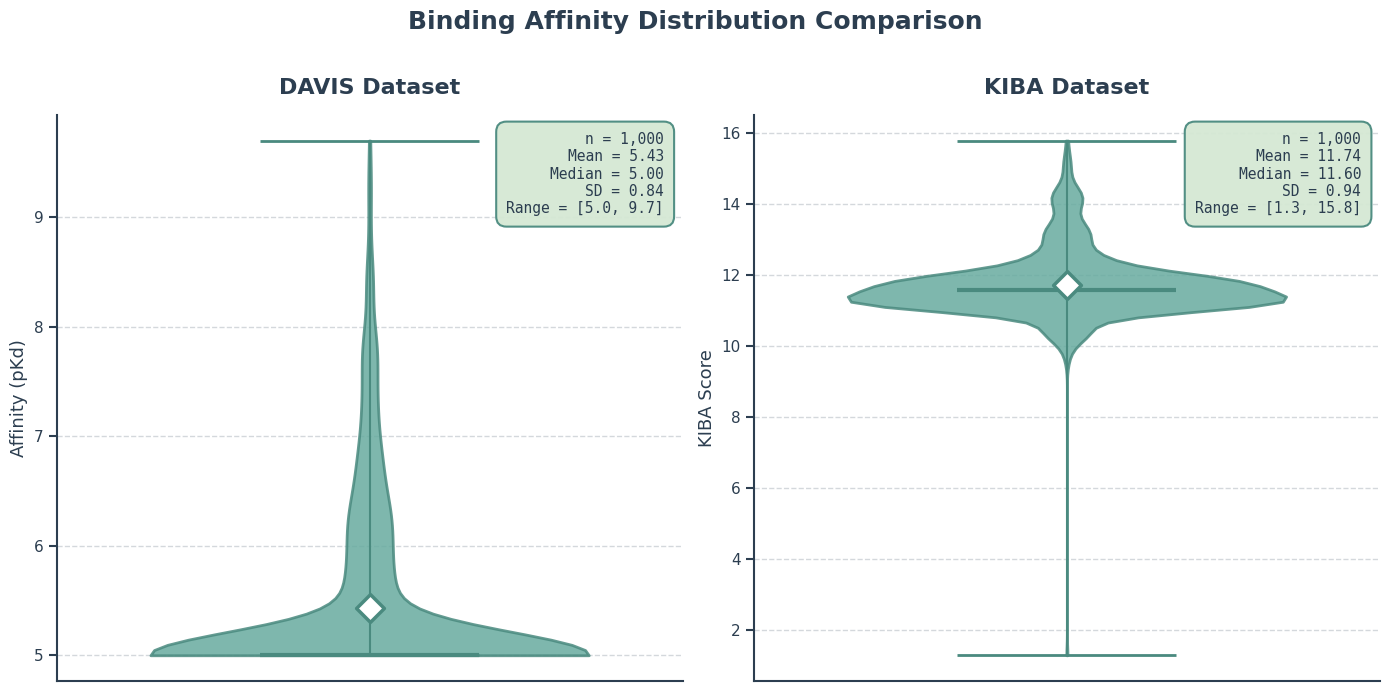

In [125]:
davis_smiles, davis_seqs, davis_keys, davis_affinities = load_davis_data(use_full=False)
kiba_smiles, kiba_seqs, kiba_keys, kiba_affinities = load_kiba_data(use_full=False)

# %%
if davis_smiles is not None and kiba_smiles is not None:
    print(f"\n✓ Davis dataset loaded successfully")
    print(f"  Samples: {len(davis_smiles)}")
    print(f"  Affinity range: [{min(davis_affinities):.2f}, {max(davis_affinities):.2f}] pKd")
    print(f"\n✓ KIBA dataset loaded successfully")
    print(f"  Samples: {len(kiba_smiles)}")
    print(f"  Affinity range: [{min(kiba_affinities):.2f}, {max(kiba_affinities):.2f}] pKd")

    # Visualize dataset distribution
    plot_dataset_distributions(
        davis_data=(davis_smiles, davis_seqs, davis_keys, davis_affinities),
        kiba_data=(kiba_smiles, kiba_seqs, kiba_keys, kiba_affinities),
        save_path='figures/ch11/dataset_distributions.png'
    )
else:
    print("\n✗ Davis dataset not found or KIBA dataset not found.")

DGraphDTA uses multiple metrics for comprehensive evaluation.

### Metrics:
1. **Concordance Index (CI)**: Measures ranking quality (primary metric)
2. **MSE/RMSE**: Regression error metrics
3. **Pearson Correlation**: Linear correlation
4. **Spearman Correlation**: Rank correlation
5. **rm²**: Modified R² accounting for systematic error

In [ ]:
def get_mse(y, f):
    """
    Mean Squared Error.
    """
    mse = ((y - f) ** 2).mean(axis=0)
    return mse

def get_rmse(y, f):
    """
    Root Mean Squared Error.
    """
    rmse = sqrt(((y - f) ** 2).mean(axis=0))
    return rmse

def get_pearson(y, f):
    """
    Pearson correlation coefficient.
    """
    rp = np.corrcoef(y, f)[0, 1]
    return rp

def get_spearman(y, f):
    """
    Spearman rank correlation.
    """
    rs = stats.spearmanr(y, f)[0]
    return rs

def concordance_index(y_true, y_pred):
    """
    Calculate Concordance Index (CI) - a ranking metric.

    CI measures how well the model ranks drug-protein pairs.
    CI = 1.0 means perfect ranking, CI = 0.5 is random.

    Args:
        y_true: True affinity values
        y_pred: Predicted affinity values

    Returns:
        Concordance index (float between 0 and 1)
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Sort by true values
    ind = np.argsort(y_true)
    y_true = y_true[ind]
    y_pred = y_pred[ind]

    concordant = 0
    total = 0

    for i in range(len(y_true) - 1):
        for j in range(i + 1, len(y_true)):
            if y_true[i] != y_true[j]:
                total += 1
                if (y_true[i] < y_true[j] and y_pred[i] < y_pred[j]) or \
                   (y_true[i] > y_true[j] and y_pred[i] > y_pred[j]):
                    concordant += 1
                elif y_pred[i] == y_pred[j]:
                    concordant += 0.5

    if total == 0:
        return 0.5

    return concordant / total

def r_squared_error(y_obs, y_pred):
    """
    R² error for rm² calculation.
    """
    y_obs = np.array(y_obs)
    y_pred = np.array(y_pred)
    y_obs_mean = [np.mean(y_obs) for y in y_obs]
    y_pred_mean = [np.mean(y_pred) for y in y_pred]

    mult = sum((y_pred - y_pred_mean) * (y_obs - y_obs_mean))
    mult = mult * mult

    y_obs_sq = sum((y_obs - y_obs_mean) * (y_obs - y_obs_mean))
    y_pred_sq = sum((y_pred - y_pred_mean) * (y_pred - y_pred_mean))

    return mult / float(y_obs_sq * y_pred_sq)

def get_k(y_obs, y_pred):
    """
    Scaling factor for rm² calculation.
    """
    y_obs = np.array(y_obs)
    y_pred = np.array(y_pred)
    return sum(y_obs * y_pred) / float(sum(y_pred * y_pred))

def squared_error_zero(y_obs, y_pred):
    """
    R²_0 for rm² calculation.
    """
    k = get_k(y_obs, y_pred)

    y_obs = np.array(y_obs)
    y_pred = np.array(y_pred)
    y_obs_mean = [np.mean(y_obs) for y in y_obs]
    upp = sum((y_obs - (k * y_pred)) * (y_obs - (k * y_pred)))
    down = sum((y_obs - y_obs_mean) * (y_obs - y_obs_mean))

    return 1 - (upp / float(down))

def get_rm2(ys_orig, ys_line):
    """
    Modified R² metric accounting for systematic error.

    Args:
        ys_orig: True values
        ys_line: Predicted values

    Returns:
        rm² value
    """
    r2 = r_squared_error(ys_orig, ys_line)
    r02 = squared_error_zero(ys_orig, ys_line)

    return r2 * (1 - np.sqrt(np.absolute((r2 * r2) - (r02 * r02))))

def calculate_metrics(Y, P, dataset_name=''):
    """
    Calculate all evaluation metrics.

    Args:
        Y: True affinity values
        P: Predicted affinity values
        dataset_name: Dataset name for display

    Returns:
        Dictionary of metric values
    """
    metrics = {
        'mse': get_mse(Y, P),
        'rmse': get_rmse(Y, P),
        'pearson': get_pearson(Y, P),
        'spearman': get_spearman(Y, P),
        'cindex': concordance_index(Y, P),
        'rm2': get_rm2(Y, P)
    }

    if dataset_name:
        print(f"\nMetrics for {dataset_name}:")
        print(f"  MSE: {metrics['mse']:.4f}")
        print(f"  RMSE: {metrics['rmse']:.4f}")
        print(f"  Pearson: {metrics['pearson']:.4f}")
        print(f"  Spearman: {metrics['spearman']:.4f}")
        print(f"  CI (method 1): {metrics['cindex']:.4f}")
        print(f"  CI (method 2): {metrics['ci']:.4f}")
        print(f"  rm²: {metrics['rm2']:.4f}")

    return metrics

Training. 

### Hyperparameters:
- Batch size: 512 (train and test)
- Learning rate: 0.001
- Optimizer: Adam
- Loss: MSELoss
- Epochs: 2000 (with early stopping)
- Dropout: 0.2

In [ ]:
def train(model, device, train_loader, optimizer, epoch, log_interval=None):
    """
    Training function for one epoch.

    Args:
        model: DGraphDTA model
        device: torch device
        train_loader: DataLoader for training data
        optimizer: Optimizer
        epoch: Current epoch number
        log_interval: Logging frequency (default: CONFIG['log_interval'])
    """
    if log_interval is None:
        log_interval = CONFIG['log_interval']
    print(f'Training on {len(train_loader.dataset)} samples...')
    model.train()
    loss_fn = nn.MSELoss()

    for batch_idx, data in enumerate(train_loader):
        data_mol = data[0].to(device)
        data_pro = data[1].to(device)

        optimizer.zero_grad()
        output = model(data_mol, data_pro)
        loss = loss_fn(output, data_mol.y.view(-1, 1).float().to(device))
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print(f'Train epoch: {epoch} [{batch_idx * len(data_mol.y)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

def predicting(model, device, loader):
    """
    Prediction function.

    Args:
        model: DGraphDTA model
        device: torch device
        loader: DataLoader

    Returns:
        Tuple of (true_labels, predictions)
    """
    model.eval()
    total_preds = torch.Tensor()
    total_labels = torch.Tensor()
    print(f'Make prediction for {len(loader.dataset)} samples...')

    with torch.no_grad():
        for data in loader:
            data_mol = data[0].to(device)
            data_pro = data[1].to(device)
            output = model(data_mol, data_pro)
            total_preds = torch.cat((total_preds, output.cpu()), 0)
            total_labels = torch.cat((total_labels, data_mol.y.view(-1, 1).cpu()), 0)

    return total_labels.numpy().flatten(), total_preds.numpy().flatten()

For demonstration purposes, we create a simplified dataset using only sequence features (without PSSM) to avoid the requirement for preprocessing files.

In [ ]:
def create_simplified_protein_features(protein_sequence: str) -> np.ndarray:
    """
    Create simplified protein node features without PSSM.

    Uses only one-hot encoding and biochemical properties (33 dimensions).
    This allows demo training without MSA preprocessing files.

    Args:
        protein_sequence: Protein sequence string

    Returns:
        Feature matrix of shape (seq_length, 33)
    """
    return seq_feature(protein_sequence)

def create_demo_dataset(smiles_list, protein_sequences, affinity_values,
                        num_samples=None, train_ratio=None, seed=None):
    """
    Create reproducible demo dataset for architecture comparison.

    Args:
        smiles_list: List of SMILES strings
        protein_sequences: List of protein sequences
        affinity_values: List of affinity values
        num_samples: Number of samples (default: CONFIG['demo_samples'])
        train_ratio: Train/val split ratio (default: CONFIG['demo_train_ratio'])
        seed: Random seed (default: CONFIG['seed'])

    Returns:
        Tuple of (train_dataset, val_dataset, smile_graph, protein_graph)
    """
    if num_samples is None:
        num_samples = CONFIG['demo_samples']
    if train_ratio is None:
        train_ratio = CONFIG['demo_train_ratio']
    if seed is None:
        seed = CONFIG['seed']

    # Set seed for reproducibility
    np.random.seed(seed)
    random.seed(seed)

    # Sample subset
    total_samples = min(num_samples, len(smiles_list))
    indices = np.random.choice(len(smiles_list), total_samples, replace=False)

    demo_smiles = [smiles_list[i] for i in indices]
    demo_sequences = [protein_sequences[i] for i in indices]
    demo_affinities = [affinity_values[i] for i in indices]

    print(f"\n{'='*80}")
    print("Creating Demo Dataset")
    print(f"{'='*80}")
    print(f"Total samples: {total_samples}")

    # Pre-compute molecular graphs
    smile_graph = {}
    print("Converting molecules to graphs...")
    for smiles in tqdm(set(demo_smiles), desc="Molecular graphs"):
        num_atoms, features, edges = smile_to_graph(smiles)
        smile_graph[smiles] = (num_atoms, features, edges)

    # Pre-compute simplified protein graphs (without contact maps)
    # Use k-nearest neighbor graph based on sequence position
    protein_graph = {}
    print("Creating simplified protein graphs...")
    for seq in tqdm(set(demo_sequences), desc="Protein graphs"):
        target_size = len(seq)
        # Simplified features (no PSSM)
        target_features = create_simplified_protein_features(seq)

        # Create k-NN graph: connect each residue to k neighbors on each side
        k = 3
        target_edge_index = []
        for i in range(target_size):
            # Self-loop
            target_edge_index.append([i, i])
            # Connect to neighbors
            for offset in range(1, k + 1):
                if i + offset < target_size:
                    target_edge_index.append([i, i + offset])
                    target_edge_index.append([i + offset, i])

        protein_graph[seq] = (target_size, target_features, np.array(target_edge_index))

    # Split into train/val
    split_idx = int(total_samples * train_ratio)
    train_indices = list(range(split_idx))
    val_indices = list(range(split_idx, total_samples))

    # Create datasets
    train_smiles = [demo_smiles[i] for i in train_indices]
    train_sequences = [demo_sequences[i] for i in train_indices]
    train_affinities = [demo_affinities[i] for i in train_indices]

    val_smiles = [demo_smiles[i] for i in val_indices]
    val_sequences = [demo_sequences[i] for i in val_indices]
    val_affinities = [demo_affinities[i] for i in val_indices]

    train_dataset = DTADataset(
        root='/tmp',
        dataset='demo_train',
        xd=train_smiles,
        y=train_affinities,
        smile_graph=smile_graph,
        target_key=train_sequences,
        target_graph=protein_graph
    )

    val_dataset = DTADataset(
        root='/tmp',
        dataset='demo_val',
        xd=val_smiles,
        y=val_affinities,
        smile_graph=smile_graph,
        target_key=val_sequences,
        target_graph=protein_graph
    )

    print(f"\n✓ Demo dataset created:")
    print(f"  Train: {len(train_dataset)} samples")
    print(f"  Val: {len(val_dataset)} samples")

    return train_dataset, val_dataset

def train_demo_model(train_dataset, val_dataset, model_type='GCN',
                     num_epochs=None, batch_size=None, learning_rate=None):
    """
    Train a single model on demo dataset with validation tracking.

    Args:
        train_dataset: Training DTADataset
        val_dataset: Validation DTADataset
        model_type: 'GCN', 'GAT', or 'GIN'
        num_epochs: Number of epochs (default: CONFIG['demo_epochs'])
        batch_size: Batch size (default: CONFIG['demo_batch_size'])
        learning_rate: Learning rate (default: CONFIG['learning_rate'])

    Returns:
        Tuple of (trained_model, history_dict)
    """
    if num_epochs is None:
        num_epochs = CONFIG['demo_epochs']
    if batch_size is None:
        batch_size = CONFIG['demo_batch_size']
    if learning_rate is None:
        learning_rate = CONFIG['learning_rate']

    # Create data loaders
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate
    )

    # Create model (using simplified 33-dim protein features)
    if model_type == 'GCN':
        model = GNNNet(
            num_features_pro=CONFIG['num_features_pro_simplified'],
            num_features_mol=CONFIG['num_features_mol']
        ).to(device)
    elif model_type == 'GAT':
        model = GNNNet_GAT(
            num_features_pro=CONFIG['num_features_pro_simplified'],
            num_features_mol=CONFIG['num_features_mol']
        ).to(device)
    elif model_type == 'GIN':
        model = GNNNet_GIN(
            num_features_pro=CONFIG['num_features_pro_simplified'],
            num_features_mol=CONFIG['num_features_mol']
        ).to(device)
    else:
        raise ValueError(f"Unknown model type: {model_type}")

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_ci': [],
        'val_rmse': [],
        'val_pearson': []
    }

    print(f"\nTraining {model_type} model for {num_epochs} epochs...")

    for epoch in range(1, num_epochs + 1):
        # Training
        model.train()
        train_losses = []
        for data in train_loader:
            data_mol = data[0].to(device)
            data_pro = data[1].to(device)

            optimizer.zero_grad()
            output = model(data_mol, data_pro)
            loss = loss_fn(output, data_mol.y.view(-1, 1).float().to(device))
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        avg_train_loss = np.mean(train_losses)
        history['train_loss'].append(avg_train_loss)

        # Validation
        model.eval()
        val_losses = []
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for data in val_loader:
                data_mol = data[0].to(device)
                data_pro = data[1].to(device)

                output = model(data_mol, data_pro)
                loss = loss_fn(output, data_mol.y.view(-1, 1).float().to(device))

                val_losses.append(loss.item())
                val_preds.extend(output.cpu().numpy().flatten())
                val_labels.extend(data_mol.y.cpu().numpy().flatten())

        avg_val_loss = np.mean(val_losses)
        val_preds = np.array(val_preds)
        val_labels = np.array(val_labels)

        # Calculate metrics
        val_ci = concordance_index(val_labels, val_preds)
        val_rmse = get_rmse(val_labels, val_preds)
        val_pearson = get_pearson(val_labels, val_preds)

        history['val_loss'].append(avg_val_loss)
        history['val_ci'].append(val_ci)
        history['val_rmse'].append(val_rmse)
        history['val_pearson'].append(val_pearson)

        if epoch % 5 == 0 or epoch == 1:
            print(f"Epoch {epoch:3d}: "
                  f"train_loss={avg_train_loss:.4f}, "
                  f"val_loss={avg_val_loss:.4f}, "
                  f"val_CI={val_ci:.4f}, "
                  f"val_RMSE={val_rmse:.4f}")

    print(f"\n✓ Training complete!")
    print(f"  Final Val CI: {history['val_ci'][-1]:.4f}")
    print(f"  Final Val RMSE: {history['val_rmse'][-1]:.4f}")

    return model, history

### Pre-trained Model Evaluation

Load pre-trained DGraphDTA models and evaluate on test sets.
This requires the full preprocessing (MSA and contact maps).

Model files:
- artifacts/ch11/models/model_GNNNet_davis.model
- artifacts/ch11/models/model_GNNNet_kiba.model

For this evaluation, we use the legacy checkpoint and GNNNetLegacy class from the original DGraphDTA codebase.

In [ ]:
class GNNNetLegacy(nn.Module):
    """
    Dual Graph Neural Network for Drug-Target Affinity Prediction.

    Follows gnn.py:9-99 exactly, using GCN layers.

    Args:
        n_output: Number of output values (1 for regression)
        num_features_pro: Protein node feature dimension (54 for full, 28 for simplified)
        num_features_mol: Molecular node feature dimension (78)
        output_dim: Embedding dimension (128)
        dropout: Dropout probability (0.2)
    """

    def __init__(self, n_output=1, num_features_pro=54, num_features_mol=78,
                 output_dim=128, dropout=0.2):
        super(GNNNetLegacy, self).__init__()

        print('GNNNet Loaded')
        self.n_output = n_output

        # Molecular GNN branch 
        self.mol_conv1 = GCNConv(num_features_mol, num_features_mol, bias=False)
        self.mol_conv2 = GCNConv(num_features_mol, num_features_mol * 2, bias=False)
        self.mol_conv3 = GCNConv(num_features_mol * 2, num_features_mol * 4, bias=False)
        self.mol_fc_g1 = nn.Linear(num_features_mol * 4, 1024)
        self.mol_fc_g2 = nn.Linear(1024, output_dim)

        # Protein GNN branch 
        self.pro_conv1 = GCNConv(num_features_pro, num_features_pro, bias=False)
        self.pro_conv2 = GCNConv(num_features_pro, num_features_pro * 2, bias=False)
        self.pro_conv3 = GCNConv(num_features_pro * 2, num_features_pro * 4, bias=False)
        self.pro_fc_g1 = nn.Linear(num_features_pro * 4, 1024)
        self.pro_fc_g2 = nn.Linear(1024, output_dim)

        # Shared layers 
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

        # Combined prediction layers 
        self.fc1 = nn.Linear(2 * output_dim, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.out = nn.Linear(512, self.n_output)

    def forward(self, data_mol, data_pro):
        """
        Forward pass through dual GNN.

        Follows gnn.py:37-99 exactly.

        Args:
            data_mol: PyTorch Geometric Data for molecule
            data_pro: PyTorch Geometric Data for protein

        Returns:
            Predicted affinity tensor (batch_size, 1)
        """
        # Extract molecular graph data 
        mol_x, mol_edge_index, mol_batch = data_mol.x, data_mol.edge_index, data_mol.batch

        # Extract protein graph data
        target_x, target_edge_index, target_batch = data_pro.x, data_pro.edge_index, data_pro.batch

        # Molecular GNN branch
        x = self.mol_conv1(mol_x, mol_edge_index)
        x = self.relu(x)
        x = self.mol_conv2(x, mol_edge_index)
        x = self.relu(x)
        x = self.mol_conv3(x, mol_edge_index)
        x = self.relu(x)
        x = global_mean_pool(x, mol_batch)  # Global pooling
        x = self.relu(self.mol_fc_g1(x))
        x = self.dropout(x)
        x = self.mol_fc_g2(x)
        x = self.dropout(x)

        # Protein GNN branch 
        xt = self.pro_conv1(target_x, target_edge_index)
        xt = self.relu(xt)
        xt = self.pro_conv2(xt, target_edge_index)
        xt = self.relu(xt)
        xt = self.pro_conv3(xt, target_edge_index)
        xt = self.relu(xt)
        xt = global_mean_pool(xt, target_batch)  # Global pooling 
        xt = self.relu(self.pro_fc_g1(xt))
        xt = self.dropout(xt)
        xt = self.pro_fc_g2(xt)
        xt = self.dropout(xt)

        # Concatenate and predict 
        xc = torch.cat((x, xt), 1)
        xc = self.fc1(xc)
        xc = self.relu(xc)
        xc = self.dropout(xc)
        xc = self.fc2(xc)
        xc = self.relu(xc)
        xc = self.dropout(xc)
        out = self.out(xc)

        return out

In [ ]:
def convert_legacy_state_dict(old_state_dict):
    """
    Convert PyTorch Geometric 1.3.2 GCNConv state dict to 2.6.1 format.
    
    Changes:
    - Remaps: mol_conv1.weight -> mol_conv1.lin.weight
    - Transposes weight matrices (old: [out, in] -> new: [in, out])
    - Handles missing bias (initializes to zero if needed)
    
    Args:
        old_state_dict: State dict from PyG 1.3.2 model
        
    Returns:
        Converted state dict compatible with PyG 2.6.1
    """
    new_state_dict = {}
    
    for key, value in old_state_dict.items():
        # Check if this is a GCNConv layer weight
        if any(conv in key for conv in ['mol_conv', 'pro_conv']):
            if key.endswith('.weight'):
                # Insert .lin before .weight AND transpose the matrix
                parts = key.rsplit('.', 1)
                new_key = f"{parts[0]}.lin.{parts[1]}"
                new_state_dict[new_key] = value.t()  # Transpose: [out, in] -> [in, out]
            elif key.endswith('.bias'):
                # Insert .lin before .bias (no transpose for bias)
                parts = key.rsplit('.', 1)
                new_key = f"{parts[0]}.lin.{parts[1]}"
                new_state_dict[new_key] = value
            else:
                # Keep other GCNConv parameters as-is
                new_state_dict[key] = value
        else:
            # Non-GCNConv layers remain unchanged
            new_state_dict[key] = value
    
    return new_state_dict

def load_pretrained_model(model_path, num_features_pro=None, num_features_mol=None):
    """
    Load pre-trained DGraphDTA model.

    Args:
        model_path: Path to model checkpoint
        num_features_pro: Protein feature dimension (default: CONFIG['num_features_pro'])
        num_features_mol: Molecular feature dimension (default: CONFIG['num_features_mol'])

    Returns:
        Loaded model
    """
    if num_features_pro is None:
        num_features_pro = CONFIG['num_features_pro']
    if num_features_mol is None:
        num_features_mol = CONFIG['num_features_mol']

    model = GNNNetLegacy(
        num_features_pro=num_features_pro,
        num_features_mol=num_features_mol
    ).to(device)

    checkpoint = torch.load(model_path, map_location=device)
    converted_state_dict = convert_legacy_state_dict(checkpoint)
    model.load_state_dict(converted_state_dict, strict=False)

    model.eval()

    print(f"✓ Loaded legacy model from {model_path} (converted PyG 1.3.2 -> 2.6.1)")
    return model

def data_to_csv(csv_file, datalist):
    with open(csv_file, 'w') as f:
        f.write('compound_iso_smiles,target_sequence,target_key,affinity\n')
        for data in datalist:
            f.write(','.join(map(str, data)) + '\n')

def create_dataset_for_test(dataset):
    # load dataset
    dataset_path = f"{CONFIG['data_dir']}/{dataset}/"
    test_fold = json.load(open(dataset_path + 'folds/test_fold_setting1.txt'))
    ligands = json.load(open(dataset_path + 'ligands_can.txt'), object_pairs_hook=OrderedDict)
    proteins = json.load(open(dataset_path + 'proteins.txt'), object_pairs_hook=OrderedDict)
    affinity = pickle.load(open(dataset_path + 'Y', 'rb'), encoding='latin1')
    # load contact and aln
    msa_path = f"{CONFIG['data_dir']}/{dataset}/aln"
    contact_path = f"{CONFIG['data_dir']}/{dataset}/pconsc4"
    msa_list = []
    contact_list = []
    for key in proteins:
        msa_list.append(os.path.join(msa_path, key + '.aln'))
        contact_list.append(os.path.join(contact_path, key + '.npy'))

    drugs = []
    prots = []
    prot_keys = []
    drug_smiles = []
    # smiles
    for d in ligands.keys():
        lg = Chem.MolToSmiles(Chem.MolFromSmiles(ligands[d]), isomericSmiles=True)
        drugs.append(lg)
        drug_smiles.append(ligands[d])
    # seqs
    for t in proteins.keys():
        prots.append(proteins[t])
        prot_keys.append(t)
    if dataset == 'davis':
        affinity = [-np.log10(y / 1e9) for y in affinity]
    affinity = np.asarray(affinity)

    valid_test_count = 0
    rows, cols = np.where(np.isnan(affinity) == False)
    rows, cols = rows[test_fold], cols[test_fold]
    temp_test_entries = []
    for pair_ind in range(len(rows)):
        # if the required files is not exist, then pass
        if not valid_target(prot_keys[cols[pair_ind]], dataset):
            continue
        ls = []
        ls += [drugs[rows[pair_ind]]]
        ls += [prots[cols[pair_ind]]]
        ls += [prot_keys[cols[pair_ind]]]
        ls += [affinity[rows[pair_ind], cols[pair_ind]]]
        temp_test_entries.append(ls)
        valid_test_count += 1
    csv_file = f"{CONFIG['data_dir']}/{dataset}_test.csv"
    data_to_csv(csv_file, temp_test_entries)
    print('dataset:', dataset)
    print('test entries:', len(test_fold), 'effective test entries', valid_test_count)

    compound_iso_smiles = drugs
    target_key = prot_keys

    # create smile graph
    smile_graph = {}
    for smile in compound_iso_smiles:
        g = smile_to_graph(smile)
        smile_graph[smile] = g

    # create target graph
    target_graph = {}
    for key in target_key:
        if not valid_target(key, dataset):  # ensure the contact and aln files exists
            continue
        g = target_to_graph(key, proteins[key], contact_path, msa_path)
        target_graph[key] = g

    # count the number of  proteins with aln and contact files
    print('effective drugs,effective prot:', len(smile_graph), len(target_graph))
    if len(smile_graph) == 0 or len(target_graph) == 0:
        raise Exception('no protein or drug, run the script for datasets preparation.')

    df_test = pd.read_csv(csv_file)
    test_drugs, test_prot_keys, test_Y = list(df_test['compound_iso_smiles']), list(df_test['target_key']), list(
        df_test['affinity'])
    test_drugs, test_prot_keys, test_Y = np.asarray(test_drugs), np.asarray(test_prot_keys), np.asarray(test_Y)
    test_dataset = DTADataset(root='data', dataset=dataset + '_test', xd=test_drugs, y=test_Y,
                              target_key=test_prot_keys, smile_graph=smile_graph, target_graph=target_graph)

    return test_dataset

def plot_prediction_results(Y_test, P_test, metrics, dataset_name='DAVIS', 
                           save_path='predictions.png'):
    """
    Create publication-quality prediction vs actual plot with diagnostics.
    
    Args:
        Y_test: True affinity values
        P_test: Predicted affinity values
        metrics: Dictionary containing 'ci', 'rmse', 'mse', 'pearson', etc.
        dataset_name: Name of dataset (for title)
        save_path: Path to save the figure
    
    Returns:
        None (saves plot to file)
    """
    # Set style
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
    
    # Color palette
    PRIMARY_COLOR = '#67AB9F'      # Main teal
    LIGHT_COLOR = '#D5E8D4'        # Light green
    ACCENT_COLOR = '#4A8A7F'       # Dark teal
    TEXT_COLOR = '#2C3E50'
    GRID_COLOR = '#E0E0E0'
    
    # Create figure with two panels
    fig, (ax_main, ax_residual) = plt.subplots(1, 2, figsize=(14, 6))
    
    # ========== Main Scatter Plot ==========
    ax_main.spines['top'].set_visible(False)
    ax_main.spines['right'].set_visible(False)
    ax_main.spines['left'].set_linewidth(1.5)
    ax_main.spines['left'].set_color(TEXT_COLOR)
    ax_main.spines['bottom'].set_linewidth(1.5)
    ax_main.spines['bottom'].set_color(TEXT_COLOR)
    
    # Scatter plot with density-based coloring
    scatter = ax_main.scatter(
        Y_test, P_test,
        c=PRIMARY_COLOR,
        alpha=0.4,
        s=30,
        edgecolors=ACCENT_COLOR,
        linewidths=0.5
    )
    
    # Perfect prediction line
    min_val = min(Y_test.min(), P_test.min())
    max_val = max(Y_test.max(), P_test.max())
    ax_main.plot([min_val, max_val], [min_val, max_val], 
                color='#E74C3C',
                linestyle='--',
                linewidth=2.5,
                label='Perfect prediction',
                alpha=0.8,
                zorder=5)
    
    # Regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(Y_test, P_test)
    regression_line = slope * Y_test + intercept
    ax_main.plot(Y_test, regression_line,
                color=ACCENT_COLOR,
                linestyle='-',
                linewidth=2,
                label=f'Fit (R² = {r_value**2:.3f})',
                alpha=0.9,
                zorder=4)
    
    # Labels and title
    ylabel = 'Predicted Affinity (pKd)' if 'DAVIS' in dataset_name.upper() else 'Predicted KIBA Score'
    xlabel = 'True Affinity (pKd)' if 'DAVIS' in dataset_name.upper() else 'True KIBA Score'
    
    ax_main.set_xlabel(xlabel, fontsize=13, fontweight='500', color=TEXT_COLOR)
    ax_main.set_ylabel(ylabel, fontsize=13, fontweight='500', color=TEXT_COLOR)
    ax_main.set_title(f'{dataset_name.upper()} Test Set Predictions', 
                     fontsize=14, fontweight='600', color=TEXT_COLOR, pad=15)
    
    # Grid
    ax_main.grid(True, alpha=0.25, linestyle='--', linewidth=1, color=GRID_COLOR)
    ax_main.set_axisbelow(True)
    
    # Legend
    legend = ax_main.legend(
        loc='upper left',
        frameon=True,
        fancybox=True,
        fontsize=10,
        edgecolor=TEXT_COLOR,
        framealpha=0.95
    )
    legend.get_frame().set_linewidth(1.5)
    
    # Tick styling
    ax_main.tick_params(axis='both', labelsize=11, colors=TEXT_COLOR, 
                       width=1.5, length=5)
    
    # Add metrics box
    metrics_lines = [
        f"n = {len(Y_test):,}",
        f"CI = {metrics.get('ci', 0):.4f}",
        f"RMSE = {metrics.get('rmse', 0):.4f}",
        f"MSE = {metrics.get('mse', 0):.4f}",
        f"Pearson r = {metrics.get('pearson', r_value):.4f}"
    ]
    metrics_text = '\n'.join(metrics_lines)
    
    ax_main.text(0.97, 0.03, metrics_text,
                transform=ax_main.transAxes,
                verticalalignment='bottom',
                horizontalalignment='right',
                fontsize=10.5,
                color=TEXT_COLOR,
                bbox=dict(
                    boxstyle='round,pad=0.7',
                    facecolor=LIGHT_COLOR,
                    edgecolor=ACCENT_COLOR,
                    alpha=0.95,
                    linewidth=1.5
                ),
                family='monospace')
    
    # ========== Residual Plot ==========
    ax_residual.spines['top'].set_visible(False)
    ax_residual.spines['right'].set_visible(False)
    ax_residual.spines['left'].set_linewidth(1.5)
    ax_residual.spines['left'].set_color(TEXT_COLOR)
    ax_residual.spines['bottom'].set_linewidth(1.5)
    ax_residual.spines['bottom'].set_color(TEXT_COLOR)
    
    # Calculate residuals
    residuals = P_test - Y_test
    
    # Residual scatter
    ax_residual.scatter(
        Y_test, residuals,
        c=PRIMARY_COLOR,
        alpha=0.4,
        s=30,
        edgecolors=ACCENT_COLOR,
        linewidths=0.5
    )
    
    # Zero line
    ax_residual.axhline(y=0, color='#E74C3C', linestyle='--', 
                       linewidth=2.5, alpha=0.8, label='Zero error')
    
    # Add standard deviation bands
    std_residual = np.std(residuals)
    ax_residual.axhline(y=std_residual, color=ACCENT_COLOR, 
                       linestyle=':', linewidth=1.5, alpha=0.6)
    ax_residual.axhline(y=-std_residual, color=ACCENT_COLOR, 
                       linestyle=':', linewidth=1.5, alpha=0.6)
    ax_residual.fill_between([min_val, max_val], -std_residual, std_residual,
                            color=LIGHT_COLOR, alpha=0.3, label='±1 SD')
    
    # Labels
    ax_residual.set_xlabel(xlabel, fontsize=13, fontweight='500', color=TEXT_COLOR)
    ax_residual.set_ylabel('Residual (Predicted - True)', 
                          fontsize=13, fontweight='500', color=TEXT_COLOR)
    ax_residual.set_title('Residual Analysis', 
                         fontsize=14, fontweight='600', color=TEXT_COLOR, pad=15)
    
    # Grid
    ax_residual.grid(True, alpha=0.25, linestyle='--', linewidth=1, color=GRID_COLOR)
    ax_residual.set_axisbelow(True)
    
    # Legend
    legend = ax_residual.legend(
        loc='best',
        frameon=True,
        fancybox=True,
        fontsize=10,
        edgecolor=TEXT_COLOR,
        framealpha=0.95
    )
    legend.get_frame().set_linewidth(1.5)
    
    # Tick styling
    ax_residual.tick_params(axis='both', labelsize=11, colors=TEXT_COLOR, 
                           width=1.5, length=5)
    
    # Overall title
    fig.suptitle(f'Model Performance Evaluation - {dataset_name.upper()} Dataset', 
                fontsize=16, fontweight='600', color=TEXT_COLOR, y=0.98)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"\n✓ Prediction plot saved to: {save_path}")
    plt.show()
    
    # Reset rcParams
    plt.rcParams.update(plt.rcParamsDefault)


def evaluate_pretrained_model(model_path, dataset_name='davis'):
    """
    Evaluate pre-trained model on test set.

    **Note**: Requires preprocessing files (aln/, pconsc4/) to be available.

    Args:
        model_path: Path to model checkpoint
        dataset_name: 'davis' or 'kiba'
    """
    print(f"\n{'='*80}")
    print(f"Evaluating Pre-trained Model: {dataset_name.upper()}")
    print(f"{'='*80}")

    # Check if preprocessing files exist
    dataset_dir = f"{CONFIG['data_dir']}/{dataset_name}"
    aln_dir = f'{dataset_dir}/aln'
    pconsc4_dir = f'{dataset_dir}/pconsc4'

    if not (os.path.exists(aln_dir) and os.path.exists(pconsc4_dir)):
        print(f"\n⚠️  Preprocessing files not found:")
        print(f"  Required: {aln_dir}/ and {pconsc4_dir}/")
        print(f"\n  To use pre-trained models, you need to:")
        print(f"  1. Download preprocessing files from:")
        print(f"     https://drive.google.com/open?id=1rqAopf_IaH3jzFkwXObQ4i-6UUwizCv")
        print(f"  2. Extract aln/ and pconsc4/ folders to {dataset_dir}/")
        print(f"\n  For this demonstration, showing the evaluation code structure.")
        return

    # Load model
    model = load_pretrained_model(model_path)

    print(f"\nLoading {dataset_name} test data...")
    print("(This requires preprocessing files to be available)")

    test_dataset = create_dataset_for_test(dataset_name)
    test_loader = DataLoader(
        test_dataset, batch_size=512, shuffle=False, collate_fn=collate
    )

    # Predict
    Y_test, P_test = predicting(model, device, test_loader)

    # Calculate metrics
    metrics = calculate_metrics(Y_test, P_test, dataset_name.upper())

    # Use improved visualization
    plot_prediction_results(
        Y_test, P_test, metrics, 
        dataset_name=dataset_name.upper(),
        save_path=f'figures/ch11/{dataset_name}_predictions.png'
    )
    
    return metrics

In [136]:
# Check if pre-trained models exist
davis_model_path = f"{CONFIG['model_dir']}/model_GNNNet_davis.model"
kiba_model_path = f"{CONFIG['model_dir']}/model_GNNNet_kiba.model"

In [137]:
if os.path.exists(davis_model_path):
    print(f"\n✓ Found pre-trained Davis model: {davis_model_path}")
    evaluate_pretrained_model(davis_model_path, 'davis')
else:
    print(f"\n✗ Pre-trained Davis model not found: {davis_model_path}")


✓ Found pre-trained Davis model: artifacts/ch11/models/model_GNNNet_davis.model

Evaluating Pre-trained Model: DAVIS
GNNNet Loaded
✓ Loaded legacy model from artifacts/ch11/models/model_GNNNet_davis.model (converted PyG 1.3.2 -> 2.6.1)

Loading davis test data...
(This requires preprocessing files to be available)
dataset: davis
test entries: 5010 effective test entries 5010


[15:51:49] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:51:49] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:51:49] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:51:49] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:51:49] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:51:49] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:51:49] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:51:49] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:51:49] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:51:49] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:51:49] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:51:49] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:51:49] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:51:49] DEPRECATION WARNING: please use GetValen

effective drugs,effective prot: 68 442
Make prediction for 5010 samples...


: 

In [64]:
if os.path.exists(kiba_model_path):
    print(f"\n✓ Found pre-trained KIBA model: {kiba_model_path}")
    evaluate_pretrained_model(kiba_model_path, 'kiba')
else:
    print(f"\n✗ Pre-trained KIBA model not found: {kiba_model_path}")


✓ Found pre-trained KIBA model: artifacts/ch11/models/model_GNNNet_kiba.model

Evaluating Pre-trained Model: KIBA
GNNNet (GCN) Loaded


RuntimeError: Error(s) in loading state_dict for GNNNet:
	Missing key(s) in state_dict: "mol_conv1.lin.weight", "mol_conv2.lin.weight", "mol_conv3.lin.weight", "pro_conv1.lin.weight", "pro_conv2.lin.weight", "pro_conv3.lin.weight". 
	Unexpected key(s) in state_dict: "mol_conv1.weight", "mol_conv2.weight", "mol_conv3.weight", "pro_conv1.weight", "pro_conv2.weight", "pro_conv3.weight". 

### GNN Architecture Comparison on the Demo Dataset

Compare different GNN architectures on the same data:
- GCN: Graph Convolutional Network (default DGraphDTA)
- GAT: Graph Attention Network (attention-weighted aggregation)
- GIN: Graph Isomorphism Network (more expressive)

In [ ]:
def plot_architecture_comparison(results, save_path='architecture_comparison.png'):
    """
    Create publication-quality comparison plots for GNN architectures.
    
    Args:
        results: Dictionary with architecture names as keys, each containing:
                - 'history': dict with 'val_loss', 'val_ci', 'val_rmse' lists
                - 'final_ci': final concordance index
                - 'final_rmse': final RMSE
                - 'final_loss': final loss
        save_path: Path to save the figure
    
    Returns:
        None (saves plot to file)
    """
    # Set style
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
    
    # Color palette - three harmonious teals/greens
    COLORS = {
        'GCN': '#4A8A7F',   # Dark teal
        'GAT': '#67AB9F',   # Medium teal (primary)
        'GIN': '#8BC9BD'    # Light teal
    }
    # Line styles for differentiation
    LINE_STYLES = {
        'GCN': '-',      # Solid
        'GAT': '--',     # Dashed
        'GIN': ':'       # Dotted
    }
    ACCENT_COLOR = '#D5E8D4'  # Light green for highlights
    TEXT_COLOR = '#2C3E50'
    GRID_COLOR = '#E0E0E0'
    
    # Create figure with custom layout
    fig = plt.figure(figsize=(16, 5))
    gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 1, 0.8], wspace=0.3)
    axes = [fig.add_subplot(gs[0, i]) for i in range(3)]
    summary_ax = fig.add_subplot(gs[0, 3])
    
    # Metrics configuration
    metrics = [
        ('val_loss', 'Validation Loss (MSE)', 'lower', 0),
        ('val_ci', 'Concordance Index (CI)', 'higher', 1),
        ('val_rmse', 'Root Mean Squared Error', 'lower', 2)
    ]
    
    architectures = list(results.keys())
    
    # Plot each metric
    for metric_key, title, direction, idx in metrics:
        ax = axes[idx]
        
        # Style axes
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(1.5)
        ax.spines['left'].set_color(TEXT_COLOR)
        ax.spines['bottom'].set_linewidth(1.5)
        ax.spines['bottom'].set_color(TEXT_COLOR)
        
        # Plot lines for each architecture
        for arch in architectures:
            history = results[arch]['history'][metric_key]
            epochs = range(1, len(history) + 1)
            
            ax.plot(epochs, history, 
                   color=COLORS[arch],
                   linestyle=LINE_STYLES[arch],
                   linewidth=2.5,
                   label=arch,
                   marker='o' if len(history) <= 15 else None,
                   markersize=4,
                   markevery=max(1, len(history) // 10),
                   alpha=0.9)
        
        # Styling
        ax.set_xlabel('Epoch', fontsize=12, fontweight='500', color=TEXT_COLOR)
        ax.set_ylabel(title.split('(')[0].strip(), fontsize=12, fontweight='500', color=TEXT_COLOR)
        ax.set_title(title, fontsize=13, fontweight='600', color=TEXT_COLOR, pad=12)
        
        # Grid
        ax.grid(True, alpha=0.25, linestyle='--', linewidth=1, color=GRID_COLOR)
        ax.set_axisbelow(True)
        
        # Legend
        legend = ax.legend(
            loc='best',
            frameon=True,
            fancybox=True,
            shadow=False,
            fontsize=10,
            edgecolor=TEXT_COLOR,
            framealpha=0.95
        )
        legend.get_frame().set_linewidth(1.5)
        
        # Tick styling
        ax.tick_params(axis='both', labelsize=10, colors=TEXT_COLOR, 
                      width=1.5, length=5)
    
    # Summary panel
    summary_ax.axis('off')
    
    # Create summary table
    summary_ax.text(0.5, 0.95, 'Final Performance', 
                   ha='center', va='top', fontsize=13, 
                   fontweight='600', color=TEXT_COLOR,
                   transform=summary_ax.transAxes)
    
    # Find best architecture by CI
    best_arch = max(architectures, key=lambda a: results[a]['final_ci'])
    
    # Create colored boxes for each architecture
    y_start = 0.75
    y_spacing = 0.22
    
    for i, arch in enumerate(architectures):
        y_pos = y_start - i * y_spacing
        
        # Highlight best architecture
        is_best = (arch == best_arch)
        bg_color = ACCENT_COLOR if is_best else 'white'
        edge_color = COLORS[arch]
        edge_width = 3 if is_best else 2
        
        # Create background box
        from matplotlib.patches import FancyBboxPatch
        box = FancyBboxPatch(
            (0.05, y_pos - 0.08), 0.9, 0.15,
            boxstyle="round,pad=0.01",
            edgecolor=edge_color,
            facecolor=bg_color,
            linewidth=edge_width,
            transform=summary_ax.transAxes,
            alpha=0.9,
            zorder=1
        )
        summary_ax.add_patch(box)
        
        # Architecture name with color indicator
        summary_ax.plot([0.1], [y_pos + 0.04], 'o', 
                       color=COLORS[arch], markersize=10,
                       transform=summary_ax.transAxes, zorder=2)
        
        summary_ax.text(0.18, y_pos + 0.04, f'{arch}', 
                       ha='left', va='center',
                       fontsize=11, fontweight='700' if is_best else '600',
                       color=TEXT_COLOR,
                       transform=summary_ax.transAxes, zorder=2)
        
        if is_best:
            summary_ax.text(0.92, y_pos + 0.04, '★', 
                           ha='right', va='center',
                           fontsize=14, color=edge_color,
                           transform=summary_ax.transAxes, zorder=2)
        
        # Metrics text
        metrics_str = f"CI: {results[arch]['final_ci']:.4f}  "
        metrics_str += f"RMSE: {results[arch]['final_rmse']:.4f}"
        
        summary_ax.text(0.525, y_pos - 0.02, metrics_str,
                       ha='center', va='center',
                       fontsize=9, family='monospace',
                       color=TEXT_COLOR,
                       transform=summary_ax.transAxes, zorder=2)
    
    # Add footer note
    summary_ax.text(0.5, 0.02, '★ Best by CI',
                   ha='center', va='bottom',
                   fontsize=9, style='italic',
                   color=TEXT_COLOR, alpha=0.7,
                   transform=summary_ax.transAxes)
    
    # Overall title
    fig.suptitle('GNN Architecture Performance Comparison', 
                fontsize=16, fontweight='600', color=TEXT_COLOR, y=0.98)
    
    # Save
    plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"\n✓ Architecture comparison plot saved to: {save_path}")
    plt.show()
    
    # Reset rcParams
    plt.rcParams.update(plt.rcParamsDefault)


def compare_architectures(smiles_list, protein_sequences, affinity_values, num_epochs=None):
    """
    Train and compare multiple GNN architectures on same dataset.

    Automatically creates a demo dataset and trains all three architecture variants.

    Args:
        smiles_list: List of SMILES strings
        protein_sequences: List of protein sequences
        affinity_values: List of affinity values
        num_epochs: Number of training epochs (default: CONFIG['demo_epochs'])

    Returns:
        Dictionary of results for each architecture
    """
    if num_epochs is None:
        num_epochs = CONFIG['demo_epochs']

    print(f"\n{'='*80}")
    print("Architecture Comparison: GCN vs GAT vs GIN")
    print(f"{'='*80}")

    # Create demo dataset (same for all architectures)
    train_dataset, val_dataset = create_demo_dataset(
        smiles_list, protein_sequences, affinity_values, num_samples=500
    )

    architectures = ['GCN', 'GAT', 'GIN']
    results = {}

    for arch in architectures:
        print(f"\n{'='*80}")
        print(f"Training {arch} Model")
        print(f"{'='*80}")

        model, history = train_demo_model(
            train_dataset, val_dataset, model_type=arch, num_epochs=num_epochs
        )

        results[arch] = {
            'model': model,
            'history': history,
            'final_ci': history['val_ci'][-1],
            'final_rmse': history['val_rmse'][-1],
            'final_loss': history['val_loss'][-1]
        }

    # Use improved visualization
    plot_architecture_comparison(results, save_path='figures/ch11/kiba_architecture_comparison.png')

    # Print summary
    print(f"\n{'='*80}")
    print("Architecture Comparison Summary")
    print(f"{'='*80}")
    print(f"\n{'Architecture':<15} {'Val Loss':<12} {'Val CI':<12} {'Val RMSE':<12}")
    print("-" * 50)
    for arch in architectures:
        print(f"{arch:<15} {results[arch]['final_loss']:<12.4f} "
              f"{results[arch]['final_ci']:<12.4f} {results[arch]['final_rmse']:<12.4f}")

    # Determine best architecture
    best_arch = max(architectures, key=lambda a: results[a]['final_ci'])
    print(f"\n✓ Best architecture by CI: {best_arch} (CI={results[best_arch]['final_ci']:.4f})")

    return results


Comparing GCN, GAT, and GIN architectures...

Architecture Comparison: GCN vs GAT vs GIN

Creating Demo Dataset
Total samples: 500
Converting molecules to graphs...


Molecular graphs:   0%|          | 0/68 [00:00<?, ?it/s][14:44:33] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:44:33] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:44:33] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:44:33] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:44:33] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:44:33] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:44:33] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:44:33] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:44:33] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:44:33] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:44:33] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:44:33] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:44:33] DEPRECATION WARNING: please use GetValence(getExplicit=Fa

Creating simplified protein graphs...


Protein graphs: 100%|██████████| 267/267 [00:07<00:00, 36.68it/s]



✓ Demo dataset created:
  Train: 400 samples
  Val: 100 samples

Training GCN Model
GNNNet (GCN) Loaded

Training GCN model for 20 epochs...
Epoch   1: train_loss=7.5372, val_loss=0.6103, val_CI=0.4499, val_RMSE=0.8156
Epoch   5: train_loss=0.8856, val_loss=0.6493, val_CI=0.4779, val_RMSE=0.8473
Epoch  10: train_loss=0.9003, val_loss=0.7247, val_CI=0.5379, val_RMSE=0.8786
Epoch  15: train_loss=0.7748, val_loss=0.9106, val_CI=0.5201, val_RMSE=0.9905
Epoch  20: train_loss=0.8393, val_loss=1.0307, val_CI=0.5485, val_RMSE=1.0543

✓ Training complete!
  Final Val CI: 0.5485
  Final Val RMSE: 1.0543

Training GAT Model
GNNNet_GAT Loaded

Training GAT model for 20 epochs...
Epoch   1: train_loss=7.6124, val_loss=0.5949, val_CI=0.5552, val_RMSE=0.8061
Epoch   5: train_loss=0.9090, val_loss=0.5960, val_CI=0.6285, val_RMSE=0.8095
Epoch  10: train_loss=0.9314, val_loss=0.7228, val_CI=0.6407, val_RMSE=0.8936
Epoch  15: train_loss=0.8557, val_loss=0.5985, val_CI=0.5734, val_RMSE=0.8072
Epoch  20: 

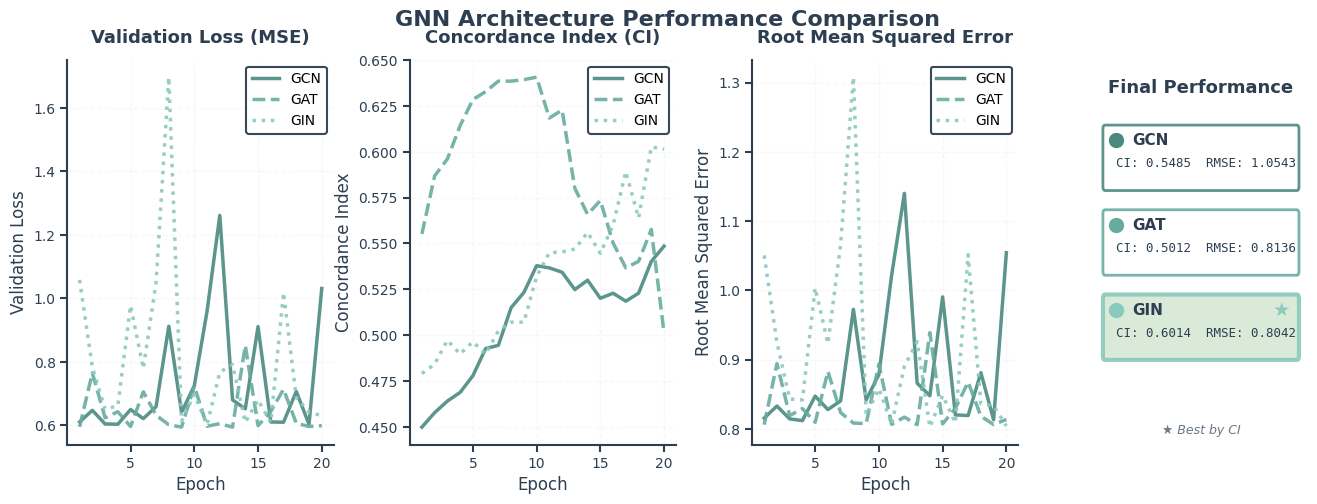


Architecture Comparison Summary

Architecture    Val Loss     Val CI       Val RMSE    
--------------------------------------------------
GCN             1.0307       0.5485       1.0543      
GAT             0.5984       0.5012       0.8136      
GIN             0.6300       0.6014       0.8042      

✓ Best architecture by CI: GIN (CI=0.6014)

✓ Architecture comparison complete!
  Comparison plot saved to 'architecture_comparison.png'


In [132]:
if davis_smiles is not None:
    print("\nComparing GCN, GAT, and GIN architectures...")
    comparison_results = compare_architectures(
        davis_smiles, davis_seqs, davis_affinities, num_epochs=20
    )
    print("\n✓ Architecture comparison complete!")
    print("  Comparison plot saved to 'architecture_comparison.png'")
else:
    print("\nSkipping architecture comparison (Davis dataset not available)")


Comparing GCN, GAT, and GIN architectures...

Architecture Comparison: GCN vs GAT vs GIN

Creating Demo Dataset
Total samples: 500
Converting molecules to graphs...


Molecular graphs:   0%|          | 0/413 [00:00<?, ?it/s][15:26:26] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:26:26] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:26:26] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:26:26] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:26:26] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:26:26] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:26:26] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:26:26] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:26:26] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:26:26] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:26:26] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:26:26] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:26:26] DEPRECATION WARNING: please use GetValence(getExplicit=F

Creating simplified protein graphs...


Protein graphs: 100%|██████████| 166/166 [00:13<00:00, 12.26it/s]



✓ Demo dataset created:
  Train: 400 samples
  Val: 100 samples

Training GCN Model
GNNNet (GCN) Loaded

Training GCN model for 20 epochs...
Epoch   1: train_loss=41.1271, val_loss=7.1289, val_CI=0.4810, val_RMSE=2.6808
Epoch   5: train_loss=1.4109, val_loss=0.4582, val_CI=0.4839, val_RMSE=0.7094
Epoch  10: train_loss=1.1353, val_loss=0.4921, val_CI=0.4899, val_RMSE=0.7348
Epoch  15: train_loss=1.2479, val_loss=0.4551, val_CI=0.5212, val_RMSE=0.7062
Epoch  20: train_loss=1.3608, val_loss=0.8891, val_CI=0.5301, val_RMSE=0.9625

✓ Training complete!
  Final Val CI: 0.5301
  Final Val RMSE: 0.9625

Training GAT Model
GNNNet_GAT Loaded

Training GAT model for 20 epochs...
Epoch   1: train_loss=40.9369, val_loss=5.1224, val_CI=0.5488, val_RMSE=2.2789
Epoch   5: train_loss=1.4987, val_loss=0.4421, val_CI=0.5580, val_RMSE=0.6955
Epoch  10: train_loss=1.1899, val_loss=0.4642, val_CI=0.5563, val_RMSE=0.7136
Epoch  15: train_loss=1.1201, val_loss=0.4628, val_CI=0.5523, val_RMSE=0.7125
Epoch  20

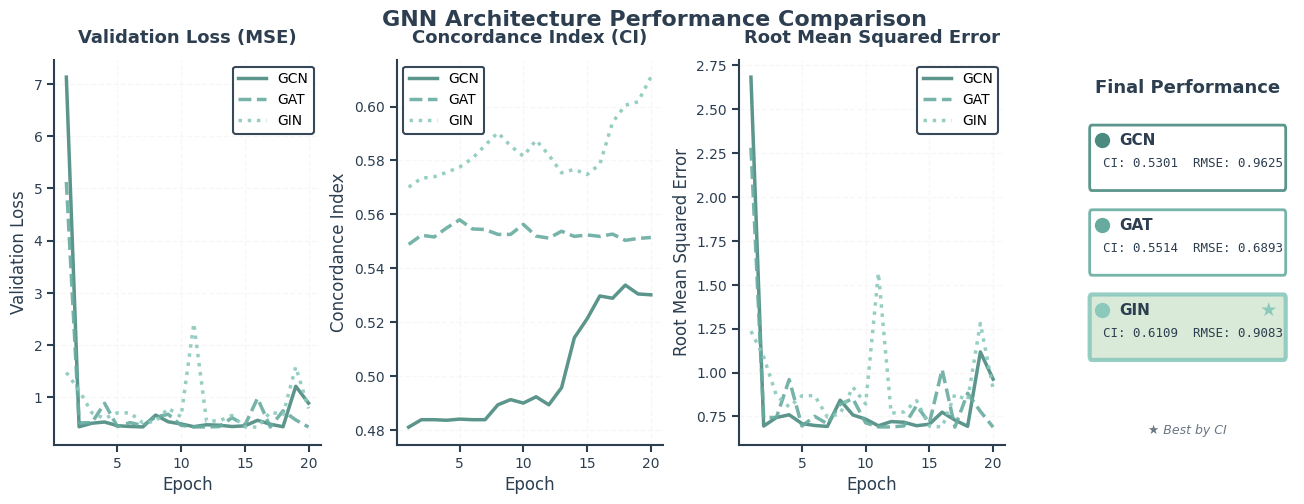


Architecture Comparison Summary

Architecture    Val Loss     Val CI       Val RMSE    
--------------------------------------------------
GCN             0.8891       0.5301       0.9625      
GAT             0.4325       0.5514       0.6893      
GIN             0.7864       0.6109       0.9083      

✓ Best architecture by CI: GIN (CI=0.6109)

✓ Architecture comparison complete!
  Comparison plot saved to 'architecture_comparison.png'


In [134]:
if kiba_smiles is not None:
    print("\nComparing GCN, GAT, and GIN architectures...")
    comparison_results = compare_architectures(
        kiba_smiles, kiba_seqs, kiba_affinities, num_epochs=20
    )
    print("\n✓ Architecture comparison complete!")
    print("  Comparison plot saved to 'architecture_comparison.png'")
else:
    print("\nSkipping architecture comparison (KIBA dataset not available)")


✓ Contact map concept figure saved to: figures/ch11/contact_map_concept.png


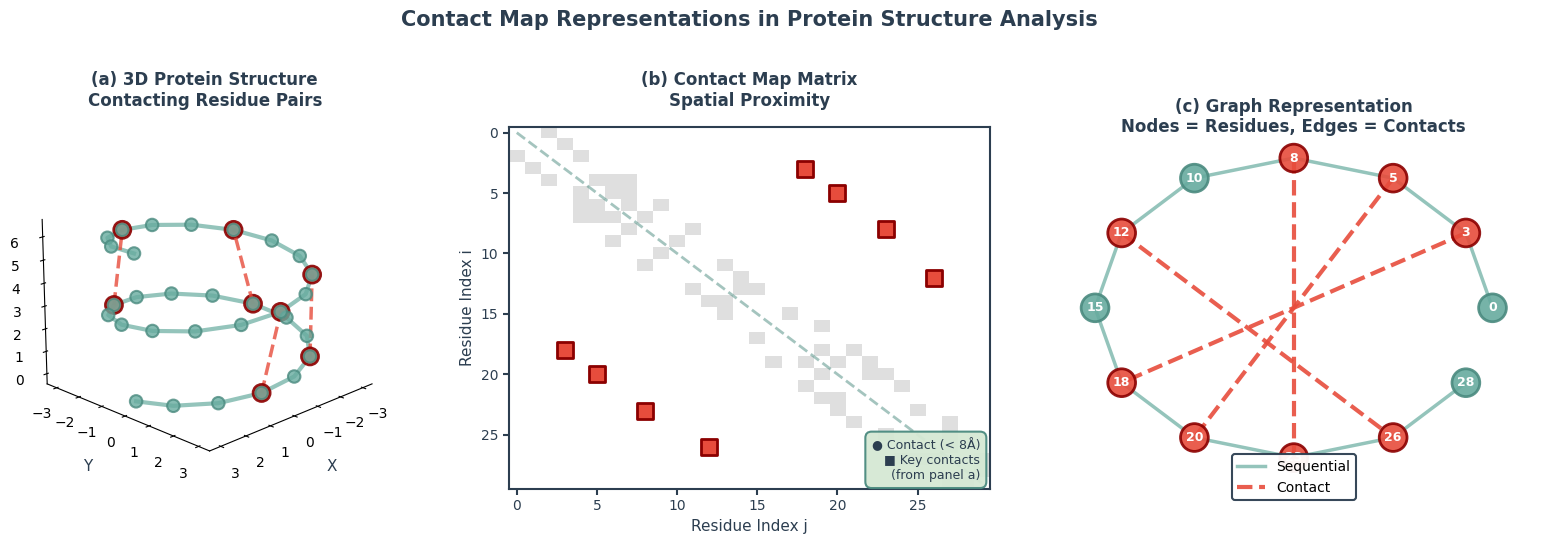

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from mpl_toolkits.mplot3d import Axes3D

def plot_contact_map_concept(save_path='contact_map_concept.png'):
    """
    Create publication-quality illustration of contact map concept.
    
    Shows three representations:
    (a) 3D protein structure with highlighted residue pairs
    (b) Contact map matrix
    (c) Graph representation
    
    Args:
        save_path: Path to save the figure
    """
    # Set style
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
    
    # Color palette
    PRIMARY_COLOR = '#67AB9F'
    LIGHT_COLOR = '#D5E8D4'
    ACCENT_COLOR = '#4A8A7F'
    TEXT_COLOR = '#2C3E50'
    CONTACT_COLOR = '#E74C3C'  # Red for contacts
    
    # Create figure with three panels
    fig = plt.figure(figsize=(16, 5.5))
    
    # ========== Panel A: 3D Protein Structure ==========
    ax1 = fig.add_subplot(131, projection='3d')
    
    # Generate a simple helical protein structure
    n_residues = 30
    t = np.linspace(0, 4*np.pi, n_residues)
    x = 3 * np.cos(t)
    y = 3 * np.sin(t)
    z = t * 0.5
    
    # Plot backbone
    ax1.plot(x, y, z, color=PRIMARY_COLOR, linewidth=3, alpha=0.7, zorder=1)
    
    # Plot residues as spheres
    ax1.scatter(x, y, z, c=PRIMARY_COLOR, s=80, alpha=0.8, 
               edgecolors=ACCENT_COLOR, linewidths=1.5, zorder=2)
    
    # Highlight contact pairs (residues that are spatially close but distant in sequence)
    contact_pairs = [(5, 20), (8, 23), (12, 26), (3, 18)]
    
    for i, j in contact_pairs:
        # Draw contact lines
        ax1.plot([x[i], x[j]], [y[i], y[j]], [z[i], z[j]], 
                color=CONTACT_COLOR, linewidth=2.5, alpha=0.8, 
                linestyle='--', zorder=3)
        
        # Highlight contact residues
        ax1.scatter([x[i], x[j]], [y[i], y[j]], [z[i], z[j]], 
                   c=CONTACT_COLOR, s=150, alpha=0.9,
                   edgecolors='darkred', linewidths=2, zorder=4)
    
    # Styling
    ax1.set_xlabel('X', fontsize=11, fontweight='500', color=TEXT_COLOR, labelpad=8)
    ax1.set_ylabel('Y', fontsize=11, fontweight='500', color=TEXT_COLOR, labelpad=8)
    ax1.set_zlabel('Z', fontsize=11, fontweight='500', color=TEXT_COLOR, labelpad=8)
    ax1.set_title('(a) 3D Protein Structure\nContacting Residue Pairs', 
                 fontsize=12, fontweight='600', color=TEXT_COLOR, pad=15)
    
    # Remove grid for cleaner look
    ax1.grid(False)
    ax1.xaxis.pane.fill = False
    ax1.yaxis.pane.fill = False
    ax1.zaxis.pane.fill = False
    ax1.xaxis.pane.set_edgecolor('w')
    ax1.yaxis.pane.set_edgecolor('w')
    ax1.zaxis.pane.set_edgecolor('w')
    
    # Set view angle
    ax1.view_init(elev=20, azim=45)
    
    # ========== Panel B: Contact Map Matrix ==========
    ax2 = fig.add_subplot(132)
    
    # Create contact map matrix
    contact_map = np.zeros((n_residues, n_residues))
    
    # Add contacts (symmetric matrix)
    for i, j in contact_pairs:
        contact_map[i, j] = 1
        contact_map[j, i] = 1
    
    # Add some additional nearby contacts for realism
    for i in range(n_residues):
        for j in range(i+1, min(i+4, n_residues)):
            if np.random.random() > 0.6:
                contact_map[i, j] = 0.5
                contact_map[j, i] = 0.5
    
    # Plot contact map
    im = ax2.imshow(contact_map, cmap='Greys', alpha=0.3, aspect='auto')
    
    # Overlay contact dots
    contact_y, contact_x = np.where(contact_map > 0.7)
    ax2.scatter(contact_x, contact_y, c=CONTACT_COLOR, s=60, 
               marker='o', alpha=0.9, edgecolors='darkred', linewidths=1.5)
    
    # Highlight the main contact pairs
    for i, j in contact_pairs:
        ax2.scatter([j, i], [i, j], c=CONTACT_COLOR, s=120, 
                   marker='s', alpha=1.0, edgecolors='darkred', linewidths=2)
    
    # Add diagonal line
    ax2.plot([0, n_residues-1], [0, n_residues-1], 
            color=ACCENT_COLOR, linestyle='--', linewidth=2, alpha=0.5)
    
    # Styling
    ax2.spines['top'].set_visible(True)
    ax2.spines['right'].set_visible(True)
    ax2.spines['left'].set_linewidth(1.5)
    ax2.spines['left'].set_color(TEXT_COLOR)
    ax2.spines['bottom'].set_linewidth(1.5)
    ax2.spines['bottom'].set_color(TEXT_COLOR)
    ax2.spines['top'].set_linewidth(1.5)
    ax2.spines['top'].set_color(TEXT_COLOR)
    ax2.spines['right'].set_linewidth(1.5)
    ax2.spines['right'].set_color(TEXT_COLOR)
    
    ax2.set_xlabel('Residue Index j', fontsize=11, fontweight='500', color=TEXT_COLOR)
    ax2.set_ylabel('Residue Index i', fontsize=11, fontweight='500', color=TEXT_COLOR)
    ax2.set_title('(b) Contact Map Matrix\nSpatial Proximity', 
                 fontsize=12, fontweight='600', color=TEXT_COLOR, pad=15)
    
    # Add legend box
    legend_text = "● Contact (< 8Å)\n■ Key contacts\n   (from panel a)"
    ax2.text(0.98, 0.02, legend_text,
            transform=ax2.transAxes,
            verticalalignment='bottom',
            horizontalalignment='right',
            fontsize=9,
            color=TEXT_COLOR,
            bbox=dict(
                boxstyle='round,pad=0.5',
                facecolor=LIGHT_COLOR,
                edgecolor=ACCENT_COLOR,
                alpha=0.95,
                linewidth=1.5
            ))
    
    ax2.set_xlim(-0.5, n_residues-0.5)
    ax2.set_ylim(n_residues-0.5, -0.5)
    ax2.tick_params(axis='both', labelsize=10, colors=TEXT_COLOR, width=1.5, length=4)
    
    # ========== Panel C: Graph Representation ==========
    ax3 = fig.add_subplot(133)
    ax3.axis('off')
    
    # Create graph
    G = nx.Graph()
    
    # Add nodes (sample subset for clarity)
    node_subset = [0, 3, 5, 8, 10, 12, 15, 18, 20, 23, 26, 28]
    for node in node_subset:
        G.add_node(node)
    
    # Add edges for sequential connections
    for i in range(len(node_subset)-1):
        G.add_edge(node_subset[i], node_subset[i+1])
    
    # Add contact edges
    contact_edges = []
    for i, j in contact_pairs:
        if i in node_subset and j in node_subset:
            G.add_edge(i, j)
            contact_edges.append((i, j))
    
    # Layout - circular for visualization
    pos = nx.circular_layout(G)
    
    # Draw sequential edges (backbone)
    sequential_edges = [(node_subset[i], node_subset[i+1]) 
                       for i in range(len(node_subset)-1)]
    nx.draw_networkx_edges(G, pos, edgelist=sequential_edges,
                          edge_color=PRIMARY_COLOR, width=2.5, 
                          alpha=0.7, ax=ax3)
    
    # Draw contact edges
    nx.draw_networkx_edges(G, pos, edgelist=contact_edges,
                          edge_color=CONTACT_COLOR, width=3, 
                          style='dashed', alpha=0.9, ax=ax3)
    
    # Draw nodes
    node_colors = [CONTACT_COLOR if any(node in edge for edge in contact_edges 
                   for edge_node in edge if edge_node == node) 
                  else PRIMARY_COLOR for node in G.nodes()]
    
    nx.draw_networkx_nodes(G, pos, node_color=node_colors,
                          node_size=400, alpha=0.9,
                          edgecolors=[ACCENT_COLOR if c == PRIMARY_COLOR 
                                    else 'darkred' for c in node_colors],
                          linewidths=2, ax=ax3)
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=9, 
                           font_color='white', font_weight='bold', ax=ax3)
    
    # Add title
    ax3.text(0.5, 1.08, '(c) Graph Representation\nNodes = Residues, Edges = Contacts',
            transform=ax3.transAxes,
            ha='center', va='top',
            fontsize=12, fontweight='600', color=TEXT_COLOR)
    
    # Add legend
    legend_elements = [
        plt.Line2D([0], [0], color=PRIMARY_COLOR, linewidth=2.5, 
                  label='Sequential', alpha=0.7),
        plt.Line2D([0], [0], color=CONTACT_COLOR, linewidth=3, 
                  linestyle='--', label='Contact', alpha=0.9)
    ]
    legend = ax3.legend(handles=legend_elements, loc='lower center',
                       frameon=True, fancybox=True, fontsize=10,
                       edgecolor=TEXT_COLOR, framealpha=0.95,
                       bbox_to_anchor=(0.5, -0.05))
    legend.get_frame().set_linewidth(1.5)
    
    # Overall title
    fig.suptitle('Contact Map Representations in Protein Structure Analysis', 
                fontsize=15, fontweight='600', color=TEXT_COLOR, y=0.98)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(save_path, dpi=500, bbox_inches='tight', facecolor='white')
    print(f"\n✓ Contact map concept figure saved to: {save_path}")
    plt.show()
    
    # Reset rcParams
    plt.rcParams.update(plt.rcParamsDefault)


# Example usage
if __name__ == "__main__":
    plot_contact_map_concept('figures/ch11/contact_map_concept.png')


✓ PSSM concept figure saved to: figures/ch11/pssm_concept.png


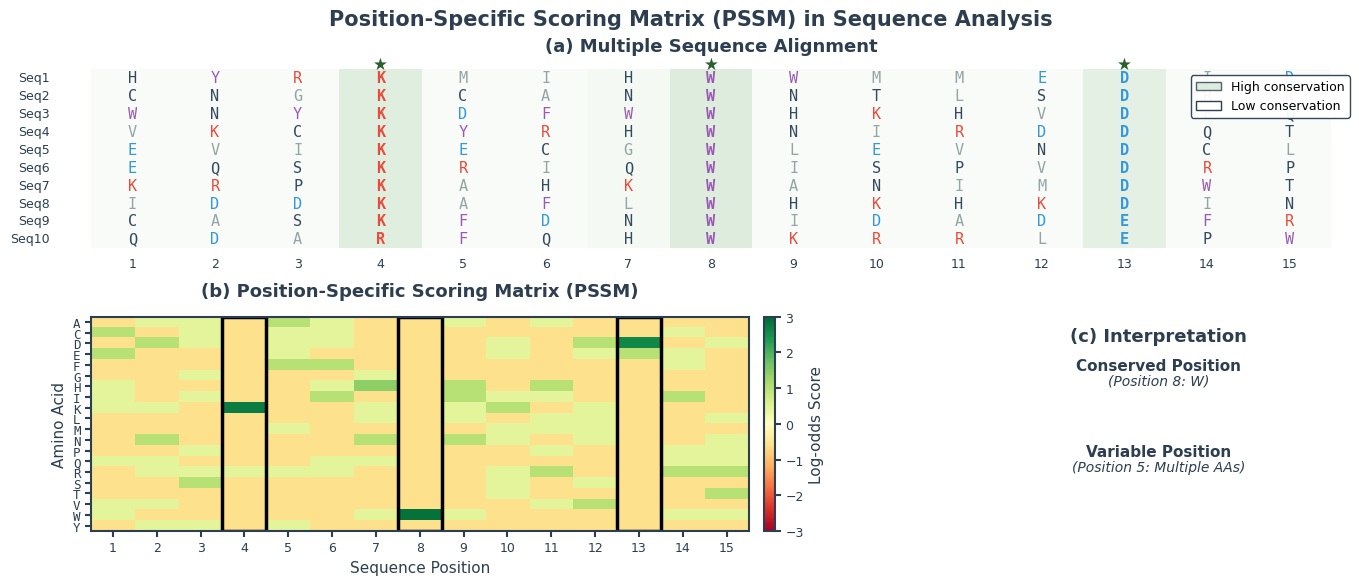

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

def plot_pssm_concept(save_path='pssm_concept.png'):
    """
    Create publication-quality illustration of PSSM concept.
    
    Shows three representations:
    (a) Multiple sequence alignment with conservation
    (b) Resulting PSSM heatmap
    (c) Interpretation of conserved vs variable positions
    
    Args:
        save_path: Path to save the figure
    """
    # Set style
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
    
    # Color palette
    PRIMARY_COLOR = '#67AB9F'
    LIGHT_COLOR = '#D5E8D4'
    ACCENT_COLOR = '#4A8A7F'
    TEXT_COLOR = '#2C3E50'
    HIGH_CONSERVATION = '#2C5F2D'  # Dark green for high conservation
    LOW_CONSERVATION = '#FFE5E5'   # Light red for variability
    
    # Create figure
    fig = plt.figure(figsize=(16, 6))
    gs = fig.add_gridspec(2, 3, height_ratios=[1, 1.2], hspace=0.35, wspace=0.3)
    
    # Define amino acids and example sequences
    amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 
                   'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
    
    # Create example alignment (10 sequences, 15 positions)
    # Position 3, 7, 12 are highly conserved, others variable
    np.random.seed(42)
    n_sequences = 10
    n_positions = 15
    
    sequences = []
    for i in range(n_sequences):
        seq = []
        for pos in range(n_positions):
            if pos == 3:  # Highly conserved K
                seq.append('K' if i < 9 else 'R')
            elif pos == 7:  # Highly conserved W
                seq.append('W')
            elif pos == 12:  # Highly conserved D
                seq.append('D' if i < 8 else 'E')
            else:  # Variable positions
                seq.append(np.random.choice(amino_acids))
        sequences.append(''.join(seq))
    
    # ========== Panel A: Multiple Sequence Alignment ==========
    ax1 = fig.add_subplot(gs[0, :])
    ax1.set_xlim(0, n_positions)
    ax1.set_ylim(0, n_sequences)
    ax1.axis('off')
    
    # Title
    ax1.text(n_positions/2, n_sequences + 0.8, 
            '(a) Multiple Sequence Alignment',
            ha='center', va='bottom', fontsize=13, 
            fontweight='600', color=TEXT_COLOR)
    
    # Color map for amino acids
    aa_colors = {
        'K': '#E74C3C', 'R': '#E74C3C',  # Positive (red)
        'D': '#3498DB', 'E': '#3498DB',  # Negative (blue)
        'W': '#9B59B6', 'F': '#9B59B6', 'Y': '#9B59B6',  # Aromatic (purple)
        'A': '#95A5A6', 'G': '#95A5A6', 'V': '#95A5A6', 
        'L': '#95A5A6', 'I': '#95A5A6', 'M': '#95A5A6',  # Hydrophobic (gray)
    }
    
    # Calculate conservation for each position
    conservation = []
    for pos in range(n_positions):
        aa_at_pos = [sequences[i][pos] for i in range(n_sequences)]
        most_common_count = max([aa_at_pos.count(aa) for aa in set(aa_at_pos)])
        conservation.append(most_common_count / n_sequences)
    
    # Draw sequences
    for i, seq in enumerate(sequences):
        y = n_sequences - i - 0.5
        for j, aa in enumerate(seq):
            x = j + 0.5
            
            # Background color based on conservation
            bg_alpha = conservation[j] * 0.8
            rect = Rectangle((j, n_sequences - i - 1), 1, 1,
                           facecolor=LIGHT_COLOR, alpha=bg_alpha,
                           edgecolor='none')
            ax1.add_patch(rect)
            
            # Amino acid letter
            color = aa_colors.get(aa, '#34495E')
            weight = 'bold' if conservation[j] > 0.7 else 'normal'
            ax1.text(x, y, aa, ha='center', va='center',
                    fontsize=11, color=color, fontweight=weight,
                    family='monospace')
    
    # Add sequence labels
    for i in range(n_sequences):
        ax1.text(-0.5, n_sequences - i - 0.5, f'Seq{i+1}',
                ha='right', va='center', fontsize=9,
                color=TEXT_COLOR, fontweight='500')
    
    # Add position numbers
    for j in range(n_positions):
        ax1.text(j + 0.5, -0.5, str(j+1),
                ha='center', va='top', fontsize=9,
                color=TEXT_COLOR, fontweight='500')
    
    # Add conservation indicator
    for j in range(n_positions):
        if conservation[j] > 0.7:
            ax1.text(j + 0.5, n_sequences + 0.3, '★',
                    ha='center', va='center', fontsize=12,
                    color=HIGH_CONSERVATION)
    
    # Legend
    legend_elements = [
        mpatches.Patch(facecolor=LIGHT_COLOR, alpha=0.8, 
                      edgecolor=TEXT_COLOR, label='High conservation'),
        mpatches.Patch(facecolor='white', edgecolor=TEXT_COLOR, 
                      label='Low conservation'),
    ]
    ax1.legend(handles=legend_elements, loc='upper right',
              frameon=True, fancybox=True, fontsize=9,
              edgecolor=TEXT_COLOR, framealpha=0.95,
              bbox_to_anchor=(1.02, 1.0))
    
    # ========== Panel B: PSSM Heatmap ==========
    ax2 = fig.add_subplot(gs[1, :2])
    
    # Calculate PSSM (simplified - using log-odds scores)
    pssm = np.zeros((len(amino_acids), n_positions))
    background_freq = 0.05  # Assume uniform background
    
    for pos in range(n_positions):
        aa_at_pos = [sequences[i][pos] for i in range(n_sequences)]
        for aa_idx, aa in enumerate(amino_acids):
            count = aa_at_pos.count(aa)
            freq = (count + 1) / (n_sequences + len(amino_acids))  # Pseudocount
            pssm[aa_idx, pos] = np.log2(freq / background_freq)
    
    # Plot heatmap
    im = ax2.imshow(pssm, cmap='RdYlGn', aspect='auto', 
                   vmin=-3, vmax=3, interpolation='nearest')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax2, pad=0.02)
    cbar.set_label('Log-odds Score', fontsize=11, 
                   fontweight='500', color=TEXT_COLOR)
    cbar.ax.tick_params(labelsize=9, colors=TEXT_COLOR, width=1.5, length=4)
    cbar.outline.set_linewidth(1.5)
    cbar.outline.set_edgecolor(TEXT_COLOR)
    
    # Styling
    ax2.spines['top'].set_visible(True)
    ax2.spines['right'].set_visible(True)
    for spine in ax2.spines.values():
        spine.set_linewidth(1.5)
        spine.set_color(TEXT_COLOR)
    
    ax2.set_xlabel('Sequence Position', fontsize=11, 
                  fontweight='500', color=TEXT_COLOR)
    ax2.set_ylabel('Amino Acid', fontsize=11, 
                  fontweight='500', color=TEXT_COLOR)
    ax2.set_title('(b) Position-Specific Scoring Matrix (PSSM)',
                 fontsize=13, fontweight='600', color=TEXT_COLOR, pad=15)
    
    # Set ticks
    ax2.set_xticks(range(n_positions))
    ax2.set_xticklabels(range(1, n_positions + 1))
    ax2.set_yticks(range(len(amino_acids)))
    ax2.set_yticklabels(amino_acids, fontsize=9, family='monospace')
    ax2.tick_params(axis='both', labelsize=9, colors=TEXT_COLOR, 
                   width=1.5, length=4)
    
    # Highlight conserved positions
    for pos in [3, 7, 12]:
        rect = Rectangle((pos - 0.5, -0.5), 1, len(amino_acids),
                        fill=False, edgecolor='black',
                        linewidth=2.5, linestyle='-')
        ax2.add_patch(rect)
    
    # ========== Panel C: Interpretation ==========
    ax3 = fig.add_subplot(gs[1, 2])
    ax3.axis('off')
    
    ax3.text(0.5, 0.95, '(c) Interpretation',
            transform=ax3.transAxes,
            ha='center', va='top',
            fontsize=13, fontweight='600', color=TEXT_COLOR)
    
    # Conserved position example
    conserved_y = 0.65
    ax3.text(0.5, conserved_y + 0.12, 'Conserved Position',
            transform=ax3.transAxes, ha='center', va='center',
            fontsize=11, fontweight='600', color=TEXT_COLOR)
    
    ax3.text(0.5, conserved_y + 0.05, '(Position 8: W)',
            transform=ax3.transAxes, ha='center', va='center',
            fontsize=10, color=TEXT_COLOR, style='italic')
    
    # Variable position example
    variable_y = 0.25
    ax3.text(0.5, variable_y + 0.12, 'Variable Position',
            transform=ax3.transAxes, ha='center', va='center',
            fontsize=11, fontweight='600', color=TEXT_COLOR)
    
    ax3.text(0.5, variable_y + 0.05, '(Position 5: Multiple AAs)',
            transform=ax3.transAxes, ha='center', va='center',
            fontsize=10, color=TEXT_COLOR, style='italic')
    
    # Overall title
    fig.suptitle('Position-Specific Scoring Matrix (PSSM) in Sequence Analysis', 
                fontsize=15, fontweight='600', color=TEXT_COLOR, y=0.98)
    
    plt.savefig(save_path, dpi=600, bbox_inches='tight', facecolor='white')
    print(f"\n✓ PSSM concept figure saved to: {save_path}")
    plt.show()
    
    # Reset rcParams
    plt.rcParams.update(plt.rcParamsDefault)


# Example usage
if __name__ == "__main__":
    plot_pssm_concept('figures/ch11/pssm_concept.png')


✓ Molecular graph representations figure saved to: figures/ch11/molecular_graph_representations.png
Aspirin: 13 heavy atoms (C, O), 13 bonds


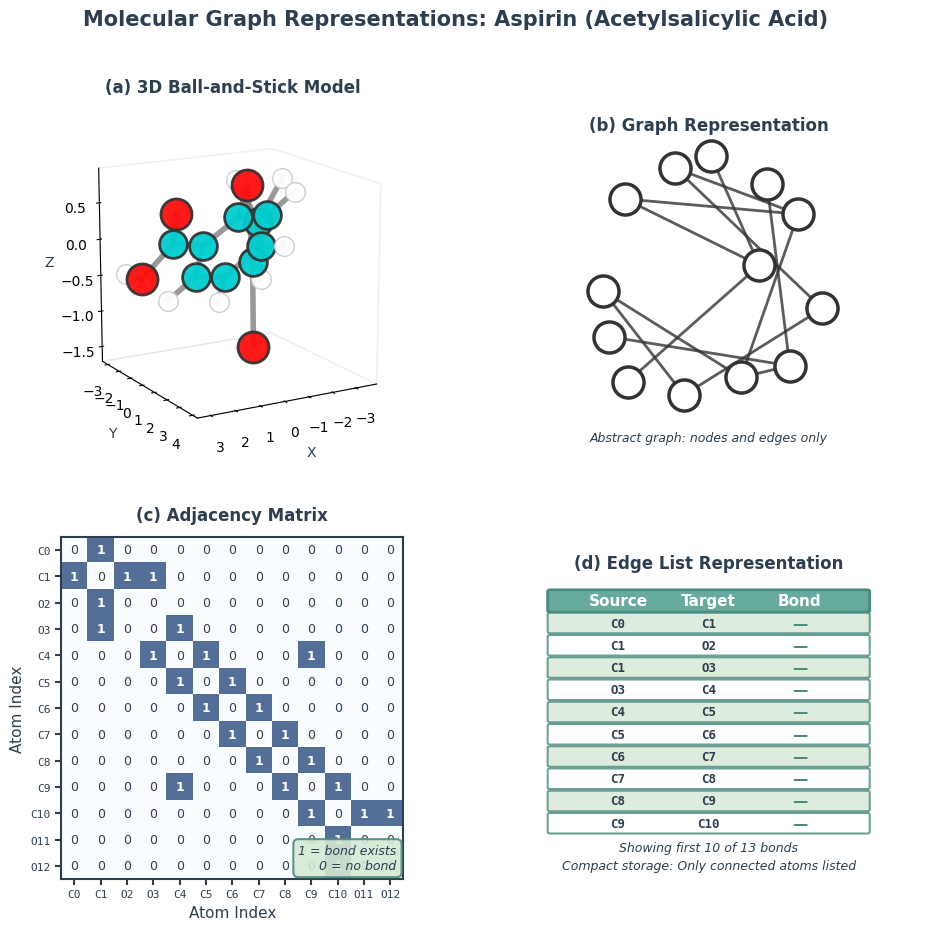

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from matplotlib.patches import FancyBboxPatch
from rdkit import Chem
from rdkit.Chem import AllChem
from mpl_toolkits.mplot3d import Axes3D

def plot_molecular_graph_representations(save_path='molecular_graph_representations.png'):
    """
    Create publication-quality illustration of molecular graph representations for Aspirin.
    
    Shows four representations:
    (a) 3D ball-and-stick model
    (b) Abstract graph representation
    (c) Adjacency matrix
    (d) Edge list
    
    Args:
        save_path: Path to save the figure
    """
    # Set style
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
    
    # Color palette
    PRIMARY_COLOR = '#67AB9F'
    LIGHT_COLOR = '#D5E8D4'
    ACCENT_COLOR = '#4A8A7F'
    TEXT_COLOR = '#2C3E50'
    
    # Atom colors (standard CPK coloring)
    ATOM_COLORS = {
        'C': '#00CED1',  # Cyan/Turquoise
        'O': '#FF0D0D',  # Red
        'N': '#3050F8',  # Blue
        'H': '#FFFFFF'   # White
    }
    
    # Create Aspirin molecule
    aspirin_smiles = 'CC(=O)Oc1ccccc1C(=O)O'
    mol = Chem.MolFromSmiles(aspirin_smiles)
    mol = Chem.AddHs(mol)
    
    # Generate 3D coordinates
    AllChem.EmbedMolecule(mol, randomSeed=42)
    AllChem.MMFFOptimizeMolecule(mol)
    
    # Get atom information
    n_atoms = mol.GetNumAtoms()
    atom_types = [atom.GetSymbol() for atom in mol.GetAtoms()]
    
    # Get 3D coordinates
    conf = mol.GetConformer()
    coords_3d = np.array([list(conf.GetAtomPosition(i)) for i in range(n_atoms)])
    
    # Get bonds
    bonds = [(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()) for bond in mol.GetBonds()]
    
    # For display purposes, use molecule without hydrogens
    mol_no_h = Chem.RemoveHs(mol)
    n_heavy = mol_no_h.GetNumAtoms()
    heavy_atom_types = [atom.GetSymbol() for atom in mol_no_h.GetAtoms()]
    bonds_no_h = [(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()) 
                  for bond in mol_no_h.GetBonds()]
    
    # Get 3D coordinates for heavy atoms
    heavy_atom_indices = [i for i, atom_type in enumerate(atom_types) if atom_type != 'H']
    coords_3d_heavy = coords_3d[heavy_atom_indices]
    
    # Create adjacency matrix
    adj_matrix = np.zeros((n_heavy, n_heavy), dtype=int)
    for i, j in bonds_no_h:
        adj_matrix[i, j] = 1
        adj_matrix[j, i] = 1
    
    # Create figure
    fig = plt.figure(figsize=(12, 10))
    gs = fig.add_gridspec(2, 2, hspace=0.25, wspace=0.05)
    
    # ========== Panel A: 3D Ball-and-Stick Model ==========
    ax1 = fig.add_subplot(gs[0, 0], projection='3d')
    
    # Draw bonds as cylinders (thick lines)
    for i, j in bonds:
        ax1.plot([coords_3d[i, 0], coords_3d[j, 0]],
                [coords_3d[i, 1], coords_3d[j, 1]],
                [coords_3d[i, 2], coords_3d[j, 2]],
                color='#808080', linewidth=4, alpha=0.8, zorder=1)
    
    # Draw atoms as spheres
    for i, atom_type in enumerate(atom_types):
        color = ATOM_COLORS[atom_type]
        size = 400 if atom_type == 'C' else (500 if atom_type in ['O', 'N'] else 200)
        edge_color = '#333333' if atom_type != 'H' else '#CCCCCC'
        edge_width = 2 if atom_type != 'H' else 1
        
        ax1.scatter([coords_3d[i, 0]], [coords_3d[i, 1]], [coords_3d[i, 2]],
                   c=color, s=size, alpha=0.95,
                   edgecolors=edge_color, linewidths=edge_width, zorder=2)
    
    # Styling
    ax1.set_xlabel('X', fontsize=10, fontweight='500', color=TEXT_COLOR)
    ax1.set_ylabel('Y', fontsize=10, fontweight='500', color=TEXT_COLOR)
    ax1.set_zlabel('Z', fontsize=10, fontweight='500', color=TEXT_COLOR)
    ax1.set_title('(a) 3D Ball-and-Stick Model',
                 fontsize=12, fontweight='600', color=TEXT_COLOR, pad=12)
    
    ax1.grid(False)
    ax1.xaxis.pane.fill = False
    ax1.yaxis.pane.fill = False
    ax1.zaxis.pane.fill = False
    ax1.xaxis.pane.set_edgecolor('#E0E0E0')
    ax1.yaxis.pane.set_edgecolor('#E0E0E0')
    ax1.zaxis.pane.set_edgecolor('#E0E0E0')
    ax1.view_init(elev=15, azim=60)
    ax1.set_box_aspect([1,1,1])
    
    # ========== Panel B: Abstract Graph Representation ==========
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.axis('off')
    
    ax2.text(0.5, 0.98, '(b) Graph Representation',
            transform=ax2.transAxes, ha='center', va='top',
            fontsize=12, fontweight='600', color=TEXT_COLOR)
    
    # Create NetworkX graph
    G = nx.Graph()
    G.add_nodes_from(range(n_heavy))
    G.add_edges_from(bonds_no_h)
    
    # Use spring layout for abstract graph representation
    pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
    
    # Scale positions to fit nicely
    scale = 0.4
    pos = {node: (scale * coords[0] + 0.5, scale * coords[1] + 0.5) 
           for node, coords in pos.items()}
    
    # Draw edges (simple black lines)
    nx.draw_networkx_edges(G, pos, edge_color='#333333',
                          width=2, alpha=0.8, ax=ax2)
    
    # Draw nodes (simple white circles with black outline)
    nx.draw_networkx_nodes(G, pos, node_color='white',
                          node_size=500, alpha=1.0,
                          edgecolors='#333333', linewidths=2.5, ax=ax2)
    
    # Optionally add node labels
    # labels = {i: str(i) for i in range(n_heavy)}
    # nx.draw_networkx_labels(G, pos, labels, font_size=8,
    #                        font_color=TEXT_COLOR, font_weight='bold', ax=ax2)
    
    ax2.set_xlim(-0.05, 1.05)
    ax2.set_ylim(-0.05, 1.05)
    ax2.set_aspect('equal')
    
    # Add note
    note = "Abstract graph: nodes and edges only"
    ax2.text(0.5, 0.02, note,
            transform=ax2.transAxes, ha='center', va='bottom',
            fontsize=9, color=TEXT_COLOR, style='italic')
    
    # ========== Panel C: Adjacency Matrix ==========
    ax3 = fig.add_subplot(gs[1, 0])
    
    # Plot matrix
    im = ax3.imshow(adj_matrix, cmap='Blues', alpha=0.7, vmin=0, vmax=1)
    
    # Add values
    for i in range(n_heavy):
        for j in range(n_heavy):
            value = adj_matrix[i, j]
            color = 'white' if value == 1 else TEXT_COLOR
            weight = 'bold' if value == 1 else 'normal'
            ax3.text(j, i, str(value), ha='center', va='center',
                    color=color, fontsize=9, fontweight=weight)
    
    # Styling
    for spine in ax3.spines.values():
        spine.set_linewidth(1.5)
        spine.set_color(TEXT_COLOR)
    
    ax3.set_xlabel('Atom Index', fontsize=11, fontweight='500', color=TEXT_COLOR)
    ax3.set_ylabel('Atom Index', fontsize=11, fontweight='500', color=TEXT_COLOR)
    ax3.set_title('(c) Adjacency Matrix',
                 fontsize=12, fontweight='600', color=TEXT_COLOR, pad=12)
    
    # Set ticks with atom labels
    tick_labels = [f"{heavy_atom_types[i]}{i}" for i in range(n_heavy)]
    ax3.set_xticks(range(n_heavy))
    ax3.set_xticklabels(tick_labels, fontsize=8, family='monospace')
    ax3.set_yticks(range(n_heavy))
    ax3.set_yticklabels(tick_labels, fontsize=8, family='monospace')
    ax3.tick_params(axis='both', labelsize=8, colors=TEXT_COLOR,
                   width=1.5, length=4)
    
    # Add explanation
    explanation = "1 = bond exists\n0 = no bond"
    ax3.text(0.98, 0.02, explanation,
            transform=ax3.transAxes, ha='right', va='bottom',
            fontsize=9, color=TEXT_COLOR, style='italic',
            bbox=dict(boxstyle='round,pad=0.4', facecolor=LIGHT_COLOR,
                     edgecolor=ACCENT_COLOR, alpha=0.9, linewidth=1.5))
    
    # ========== Panel D: Edge List ==========
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.axis('off')
    
    ax4.text(0.5, 0.95, '(d) Edge List Representation',
            transform=ax4.transAxes, ha='center', va='top',
            fontsize=12, fontweight='600', color=TEXT_COLOR)
    
    # Display first 10 bonds
    display_bonds = bonds_no_h[:10]
    
    # Create table-like display
    table_y = 0.82
    row_height = 0.065
    
    # Header
    header_box = FancyBboxPatch((0.15, table_y - 0.035), 0.7, 0.055,
                               boxstyle="round,pad=0.005",
                               facecolor=PRIMARY_COLOR, edgecolor=ACCENT_COLOR,
                               linewidth=2, transform=ax4.transAxes)
    ax4.add_patch(header_box)
    
    ax4.text(0.3, table_y - 0.007, 'Source', ha='center', va='center',
            fontsize=11, fontweight='bold', color='white',
            transform=ax4.transAxes)
    ax4.text(0.5, table_y - 0.007, 'Target', ha='center', va='center',
            fontsize=11, fontweight='bold', color='white',
            transform=ax4.transAxes)
    ax4.text(0.7, table_y - 0.007, 'Bond', ha='center', va='center',
            fontsize=11, fontweight='bold', color='white',
            transform=ax4.transAxes)
    
    # Rows
    for idx, (i, j) in enumerate(display_bonds):
        y_pos = table_y - (idx + 1) * row_height - 0.007
        
        # Alternating row colors
        row_color = LIGHT_COLOR if idx % 2 == 0 else 'white'
        row_box = FancyBboxPatch((0.15, y_pos - 0.025), 0.7, 0.05,
                                boxstyle="round,pad=0.005",
                                facecolor=row_color, edgecolor=ACCENT_COLOR,
                                linewidth=1.5, transform=ax4.transAxes,
                                alpha=0.8)
        ax4.add_patch(row_box)
        
        # Content
        ax4.text(0.3, y_pos, f"{heavy_atom_types[i]}{i}",
                ha='center', va='center', fontsize=9,
                color=TEXT_COLOR, family='monospace',
                fontweight='600', transform=ax4.transAxes)
        
        ax4.text(0.5, y_pos, f"{heavy_atom_types[j]}{j}",
                ha='center', va='center', fontsize=9,
                color=TEXT_COLOR, family='monospace',
                fontweight='600', transform=ax4.transAxes)
        
        ax4.text(0.7, y_pos, '—',
                ha='center', va='center', fontsize=11,
                color=ACCENT_COLOR, fontweight='bold',
                transform=ax4.transAxes)
    
    # Add note
    note_y = table_y - len(display_bonds) * row_height - 0.06
    note = f"Showing first {len(display_bonds)} of {len(bonds_no_h)} bonds\nCompact storage: Only connected atoms listed"
    ax4.text(0.5, note_y, note,
            transform=ax4.transAxes, ha='center', va='top',
            fontsize=9, color=TEXT_COLOR, style='italic',
            linespacing=1.5)
    
    # Overall title
    fig.suptitle('Molecular Graph Representations: Aspirin (Acetylsalicylic Acid)', 
                fontsize=15, fontweight='600', color=TEXT_COLOR, y=0.98)
    
    plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"\n✓ Molecular graph representations figure saved to: {save_path}")
    print(f"Aspirin: {n_heavy} heavy atoms (C, O), {len(bonds_no_h)} bonds")
    plt.show()
    
    # Reset rcParams
    plt.rcParams.update(plt.rcParamsDefault)


# Example usage
if __name__ == "__main__":
    plot_molecular_graph_representations('figures/ch11/molecular_graph_representations.png')